In [2]:
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from keras.regularizers import l1, l2
from tensorflow.keras import initializers
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import KFold
import keras_tuner
import keras
from keras import layers
import itertools
from sklearn.model_selection import train_test_split
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping
from keras.callbacks import LearningRateScheduler
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
import keras.backend as K
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from math import ceil
from keras.losses import mean_squared_error
import random

seed = 42

In [3]:
def plot_curves(curve_1, label_1, curve_2=None, label_2=None):
    if curve_1 is not None: 
        plt.plot(curve_1, label = label_1)
    if curve_2 is not None: 
        plt.plot(curve_2, label = label_2)   
    plt.legend()
    plt.show()
    
def set_random_seeds():
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    tf.keras.utils.set_random_seed(seed)

In [4]:
x_scaler = None
y_scaler = None

def load_monks(path, encode):
    
    train = pd.read_csv(f"{path}.train", header=None, sep=" ")
    test = pd.read_csv(f"{path}.test", header=None, sep=" ")
    
    train.drop(0, axis=1, inplace=True)
    test.drop(0, axis=1, inplace=True)
    train.drop(8, axis=1, inplace=True)
    test.drop(8, axis=1, inplace=True)
    
    y_train = train.iloc[:, 0].to_numpy().astype(np.float64)
    x_train = train.iloc[:, 1:].to_numpy().astype(np.float64)
    y_test = test.iloc[:, 0].to_numpy().astype(np.float64)
    x_test = test.iloc[:, 1:].to_numpy().astype(np.float64)
    
        
    if encode:
        
        encoder = OneHotEncoder()
        
        encoder.fit(x_train)
        x_train = encoder.transform(x_train).toarray()
        x_test = encoder.transform(x_test).toarray()
        
        
    
    print(f"Loaded {path} dataset")
    
    return x_train, y_train, x_test, y_test
    

def load_cup(scale):
    global x_scaler
    global y_scaler
    
    x_scaler = MinMaxScaler()
    y_scaler = MinMaxScaler()
    # scaler = MinMaxScaler()
    
    train = pd.read_csv("../data/ML-CUP22-INTERNAL-TR.csv", header=None, sep=",")
    test = pd.read_csv("../data/ML-CUP22-INTERNAL-TS.csv", header=None, sep=",")
    train.drop(0, axis=1, inplace=True)
    test.drop(0, axis=1, inplace=True)

    x_train = train.iloc[:, :9].to_numpy().astype(np.float64)
    y_train = train.iloc[:, 9:].to_numpy().astype(np.float64)

    x_test = test.iloc[:, :9].to_numpy().astype(np.float64)
    y_test = test.iloc[:, 9:].to_numpy().astype(np.float64) 
    # x_test_blind = test.to_numpy().astype(np.float64)
    
    # x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.1, shuffle=True, random_state=7)
    
    if scale:
        x_scaler.fit(x_train)
        x_train = x_scaler.transform(x_train)
        x_test = x_scaler.transform(x_test)
        
        y_scaler.fit(y_train)
        y_train = y_scaler.transform(y_train)
        y_test = y_scaler.transform(y_test)
        
        
    return x_train, y_train, x_test, y_test #, x_test_blind
    
    
    
def load_dataset(dataset, encode=True):
    assert dataset in ["monks1", "monks2", "monks3", "cup"]
    
    if dataset == "monks1":
        return load_monks("./../data/monks-1", encode)
    elif dataset == "monks2":
        return load_monks("./../data/monks-2", encode)
    elif dataset == "monks3":
        return load_monks("./../data/monks-3", encode)
    else:
        return load_cup(encode)

In [5]:
def median_index(array):
    n = len(array)
    med_idx = np.argsort(array)[ceil((n-1)/2)]
    # med_val = array[med_idx]
    return med_idx #, med_val

def mee(y_true_t, y_pred_t):
    return tf.reduce_mean(tf.sqrt(tf.reduce_sum(tf.square(y_true_t - y_pred_t), axis=1)))
    
    
def mse(y_true_t, y_pred_t):
    return tf.reduce_mean(tf.reduce_sum(tf.square(y_true_t - y_pred_t), axis=1))


def merge_dicts(dicts):
    merged = {}
    for d in dicts:
        merged = {**merged, **d}
    return merged


def get_attributes_num(dataset):
    return 1 if len(dataset.shape) == 1 else dataset.shape[1]


def get_params_configurations(params):
    
    keys = list(params.keys())
    keys.remove("layers")
    keys.remove("task")
    keys.remove("initialization")
    keys.remove("early_stopping")
    keys.remove("regularization")
    keys.remove("nesterov")
    keys.remove("trials_train")
    keys.remove("trials_test")
    keys.remove("learning_rate_decay")
    sorted_keys = sorted(keys)
    arguments = []
    for key in sorted_keys:
        arguments.append(params[key])
    
    arguments = tuple(arguments)
    all_params = list(itertools.product(*arguments))
        
    configurations = []
    
    for conf in all_params:
        
        dict_conf = {}
        
        for i in range(len(sorted_keys)):
            dict_conf[sorted_keys[i]] = conf[i]
        dict_conf["initialization"] = params["initialization"]
        dict_conf["early_stopping"] = params["early_stopping"]
        dict_conf["task"] = params["task"]
        dict_conf["trials_train"] = params["trials_train"]
        dict_conf["trials_test"] = params["trials_test"]
        dict_conf["nesterov"] = params["nesterov"]
        dict_conf["learning_rate_decay"] = params["learning_rate_decay"]
        
        # add regularization parameters
        for reg in params["regularization"]:
            method = reg["type"]
            
            if method == None:
                reg_dict_conf = dict_conf.copy()
                reg_dict_conf["regularization"] = {
                    "method": None
                }
                configurations.append(reg_dict_conf)
                continue
            
            for val in reg["value"]:
                reg_dict_conf = dict_conf.copy()
                reg_dict_conf["regularization"] = {
                    "method": method,
                    "value": val
                }
        
                configurations.append(reg_dict_conf)
            
        
    return configurations


def get_callbacks(config):
    
    lr_decay = config["learning_rate_decay"]
    early_stopping = config["early_stopping"]
    
    callbacks = []
    
    if early_stopping != None:
        early_stop = EarlyStopping(
            monitor=early_stopping["monitor"], 
            patience=early_stopping["patience"], 
            min_delta=early_stopping["delta"], 
        )
        callbacks.append(early_stop)

    if lr_decay != None:
        decay_epochs = lr_decay["epochs"]
        lr_final = lr_decay["lr_final"]
        linear_scheduler = get_linear_scheduler(decay_epochs, lr_final)
        scheduler = LearningRateScheduler(linear_scheduler)
        callbacks.append(scheduler)
        
    return callbacks if callbacks != [] else None
        


def get_layers_configurations(params, configurations):
    layers = params["layers"]
    layers_params_confs = []
    
    for n_layer in range(len(layers)):
        layers_params_confs.append([]) 
    
    for i in range(len(layers)):
        layer = layers[i]
        activations = layer["activations"]
        units = layer["units"]
        layer_confs = list(itertools.product(activations, units))
        for conf in layer_confs:
            conf_dict = {
                f"activations_{i+1}": conf[0],
                f"units_{i+1}": conf[1]
            }
            layers_params_confs[i].append(conf_dict)
        
    layers_confs = []
    for i in range(len(layers_params_confs)):
        confs = layers_params_confs[:i+1]
        confs = tuple(confs)
        confs = list(itertools.product(*confs))
        for conf in confs:
            layers_confs.append(merge_dicts(conf))
                
    return layers_confs



def get_configurations(params):
    
    configurations = get_params_configurations(params)
    layers_confs = get_layers_configurations(params, configurations)
    configurations = list(itertools.product(configurations, layers_confs))
    configurations_merged = []
    
    for conf in configurations:
        configurations_merged.append(merge_dicts(conf))
        
    
    return configurations_merged

            

def get_linear_scheduler(epochs, lr_final):
    
    def linear_scheduler(epoch, lr):
        if (epoch < epochs):
            alpha = epoch/epochs
            return (1-alpha)*lr + alpha*lr_final
        else:
            return lr_final
        
    return linear_scheduler
    

def get_model(config, input_size, output_size):
    
    lr = config["learning_rate"]
    momentum = config["momentum"]
    init_method = config["initialization"]["type"]
    task = config["task"]
    nesterov = config["nesterov"]
    
    reg_method = config["regularization"]["method"]
    
    if reg_method == "l1":
        reg_value = config["regularization"]["value"]
        reg = l1(reg_value)
    elif reg_method == "l2":
        reg_value = config["regularization"]["value"]
        reg = l2(reg_value)
    else:
        reg = None
    
    
    init = None
    if init_method == "uniform":
        min_val = config["initialization"]["min"]
        max_val = config["initialization"]["max"]
        init = initializers.RandomUniform(minval=min_val, maxval=max_val, seed=None)
    if init_method == "normal":
        mean = config["initialization"]["mean"]
        std = config["initialization"]["std"]
        init = initializers.RandomNormal(mean=mean, stddev=std, seed=None)
        
    
    if momentum != None:
        optimizer = SGD(learning_rate=lr, momentum=momentum, nesterov=nesterov)
    else:
        optimizer = SGD(learning_rate=lr)
    
    n_layers = 0
    for key in config.keys():
        if key.startswith("units_"):
            n_layers += 1

    model = Sequential()
    model.add(Input(input_size))
    
    for l in range(1,n_layers+1):
        activation = config[f"activations_{l}"]
        n_units = config[f"units_{l}"]
        
        model.add(Dense(n_units, activation=activation,
                        kernel_regularizer=reg, bias_regularizer=reg,
                        kernel_initializer = init, bias_initializer = init))
        
        
    if task == "classification":
        model.add(Dense(output_size, activation="sigmoid",
                        kernel_regularizer=reg, bias_regularizer=reg,
                        kernel_initializer = init, bias_initializer = init))
        
        model.compile(optimizer = optimizer, loss = 'mean_squared_error', metrics = ['accuracy'])
        
    elif task == "regression":
        model.add(Dense(output_size, activation="linear",
                        kernel_regularizer=reg, bias_regularizer=reg,
                        kernel_initializer = init, bias_initializer = init))
        
        model.compile(optimizer = optimizer, loss = 'mean_squared_error', metrics = [mee])
        
    return model
    
    
def fit_model_k_fold(x_train, y_train, config, n_folds):
    
    task = config["task"]
    
    if task == "classification":
        train_metric = "accuracy"
        val_metric = "val_accuracy"
    elif task == "regression":
        train_metric = "mee"
        val_metric = "val_mee"
    
    trials = config["trials_train"]
    max_epochs = config["max_epochs"]
    batch_size = config["batch_size"]
    
    callbacks = get_callbacks(config)

    
    kf = KFold(n_splits = n_folds, shuffle=True)

    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    fold = 1
    for train_index, val_index in kf.split(x_train, y_train):
        
        print(f"\nExecuting fold {fold}/{n_folds}")
        
        input_size = get_attributes_num(x_train)
        output_size = get_attributes_num(y_train)
        
                
        x_train_fold = x_train[train_index]
        y_train_fold = y_train[train_index]

        x_val_fold = x_train[val_index]
        y_val_fold = y_train[val_index]

        
        trials_val_loss = []
        trials_train_loss = []
        trials_val_acc = []
        trials_train_acc = []
        
        with tqdm(total=trials) as pbar:
            for trial in range(trials):
                model = get_model(config, input_size, output_size)
                history = model.fit(x_train_fold, y_train_fold, epochs=max_epochs,
                                    validation_data=(x_val_fold, y_val_fold),
                                    callbacks=callbacks, verbose = 0)

                trial_train_loss = history.history["loss"]
                trial_val_loss = history.history["val_loss"]         
                trial_train_acc = history.history[train_metric]
                trial_val_acc = history.history[val_metric]

                trials_val_loss.append(trial_val_loss[-1])
                trials_train_loss.append(trial_train_loss[-1])
                trials_val_acc.append(trial_val_acc[-1])
                trials_train_acc.append(trial_train_acc[-1])

                pbar.update(1)
            
        # get the mean metrics among the trials
        # med_idx = median_index(trials_val_loss)
        # med_val_loss = trials_val_loss[med_idx]
        # med_train_loss = trials_train_loss[med_idx]
        # med_val_acc = trials_val_acc[med_idx]
        # med_train_acc = trials_train_acc[med_idx]
        med_val_loss = np.mean(trials_val_loss)
        med_train_loss = np.mean(trials_train_loss)
        med_val_acc = np.mean(trials_val_acc)
        med_train_acc = np.mean(trials_train_acc)
        std_val_loss = np.std(trials_val_loss)
        std_train_loss = np.std(trials_train_loss)
        std_val_acc = np.std(trials_val_acc)
        std_train_acc = np.std(trials_train_acc)

        print(f"Fold {fold}/{n_folds} median val_loss: {med_val_loss}, std val_loss {std_val_loss}")
        print(f"Fold {fold}/{n_folds} median train_loss: {med_train_loss}, std train_loss {std_train_loss}")
        print(f"Fold {fold}/{n_folds} median {val_metric}: {med_val_acc}, std {val_metric} {std_val_acc}")
        print(f"Fold {fold}/{n_folds} median train_{train_metric}: {med_train_acc}, train_{train_metric} {std_train_acc}")
            
        train_losses.append(med_train_loss)
        val_losses.append(med_val_loss)
        val_accs.append(med_val_acc)
        train_accs.append(med_train_acc)
        
        fold += 1
        
    mean_train_loss = np.mean(train_losses)
    mean_val_loss = np.mean(val_losses)
    mean_train_acc = np.mean(train_accs)
    mean_val_acc = np.mean(val_accs)
    std_train_loss = np.std(train_losses)
    std_val_loss = np.std(val_losses)
    std_train_acc = np.std(train_accs)
    std_val_acc = np.std(val_accs)
    
    print(f"\nMean val_loss: {mean_val_loss}, std val_loss: {std_val_loss}")
    print(f"Mean train_loss: {mean_train_loss}, std train_loss: {std_train_loss}")
    print(f"Mean {val_metric}: {mean_val_acc}, std {val_metric}: {std_val_acc}")
    print(f"Mean train_{train_metric}: {mean_val_acc}, std train_{train_metric}: {std_train_acc}")
    
    return mean_val_loss




def fit_model_hold_out(x_train, y_train, config, val_split):
    
    task = config["task"]
    
    if task == "classification":
        train_metric = "accuracy"
        val_metric = "val_accuracy"
    elif task == "regression":
        train_metric = "mee"
        val_metric = "val_mee"
        
    trials = config["trials_train"]
    input_size = get_attributes_num(x_train)
    output_size = get_attributes_num(y_train)
    
    
    max_epochs = config["max_epochs"]
    batch_size = config["batch_size"]

    
    callbacks = get_callbacks(config)
    
    if task == "classification":
        stratify = y_train
    else:
        stratify = None
        
        
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=val_split, shuffle=True, stratify=stratify)

    
    trials_val_loss = []
    trials_train_loss = []
    trials_val_acc = []
    trials_train_acc = []
        
    with tqdm(total=trials) as pbar:
        for trial in range(trials):            
            model = get_model(config, input_size, output_size)
            history = model.fit(x_train, y_train, epochs=max_epochs, batch_size=batch_size,
                                verbose=0, validation_data=(x_val, y_val), callbacks=callbacks)
            

            trial_train_loss = history.history["loss"]
            trial_val_loss = history.history["val_loss"]         
            trial_train_acc = history.history[train_metric]
            trial_val_acc = history.history[val_metric]
            
            trials_val_loss.append(trial_val_loss[-1])
            trials_train_loss.append(trial_train_loss[-1])
            trials_val_acc.append(trial_val_acc[-1])
            trials_train_acc.append(trial_train_acc[-1])
            
            pbar.update(1)
    
    # get the median metrics among the trials
    med_idx = median_index(trials_val_loss)
    med_val_loss = trials_val_loss[med_idx]
    med_train_loss = trials_train_loss[med_idx]
    med_val_acc = trials_val_acc[med_idx]
    med_train_acc = trials_train_acc[med_idx]
    std_val_loss = np.std(trials_val_loss)
    std_train_loss = np.std(trials_train_loss)
    std_val_acc = np.std(trials_val_acc)
    std_train_acc = np.std(trials_train_acc)

    print(f"Median val_loss: {med_val_loss}, std val_loss {std_val_loss}")
    print(f"Median train_loss: {med_train_loss}, std train_loss {std_train_loss}")
    print(f"Median {val_metric}: {med_val_acc}, std {val_metric} {std_val_acc}")
    print(f"Median train_{train_metric}: {med_train_acc}, train_{train_metric} {std_train_acc}")
    
    return med_val_loss
    
    

def fit_final_model(x_train, y_train, config):
    global y_scaler
    
    task = config["task"]
    trails = config["trials_test"]
    
    if task == "classification":
        train_metric = "accuracy"
        val_metric = "val_accuracy"
    elif task == "regression":
        train_metric = "mee"
        val_metric = "val_mee"
    val_loss = "val_mse"
    train_loss = "mse"

    max_epochs = config["max_epochs"]
    batch_size = config["batch_size"]
    trials = config["trials_test"]
    
    '''if config["early_stopping"]["monitor"] == "val_loss":
        config["early_stopping"]["monitor"] = "loss"'''
        
    callbacks = get_callbacks(config)
    
    input_size = get_attributes_num(x_train)
    output_size = get_attributes_num(y_train)
    
    
    trials_val_loss = []
    trials_train_loss = []
    trials_val_acc = []
    trials_train_acc = []
    
    trials_history_val_loss = []
    trials_history_train_loss = []
    trials_history_val_acc = []
    trials_history_train_acc = []   
    
    models = []
    
    if task == "classification":
        stratify = y_train
    else:
        stratify = None
    
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, shuffle=True, stratify=stratify)
    
    with tqdm(total=trials) as pbar:
        for trial in range(trials):
            
            model = get_model(config, input_size, output_size)
            history = model.fit(x_train, y_train, epochs=max_epochs, validation_data=(x_val, y_val),
                                batch_size=batch_size, verbose=0, callbacks=callbacks)

            models.append(model)

            trial_train_loss = history.history["loss"]
            trial_val_loss = history.history["val_loss"]         
            trial_train_acc = history.history[train_metric]
            trial_val_acc = history.history[val_metric]

            trials_val_loss.append(trial_val_loss[-1])
            trials_train_loss.append(trial_train_loss[-1])
            trials_val_acc.append(trial_val_acc[-1])
            trials_train_acc.append(trial_train_acc[-1])

            trials_history_val_loss.append(trial_val_loss)
            trials_history_train_loss.append(trial_train_loss)
            trials_history_val_acc.append(trial_val_acc)
            trials_history_train_acc.append(trial_train_acc)

            print(f"Trial {trial+1}/{trials} {val_loss}: {trial_val_loss[-1]}")
            print(f"Trial {trial+1}/{trials} train_{train_loss}: {trial_train_loss[-1]}")
            print(f"Trial {trial+1}/{trials} {val_metric}: {trial_val_acc[-1]}")
            print(f"Trial {trial+1}/{trials} train_{train_metric}: {trial_train_acc[-1]}")

            pbar.update(1)
        
    # get the mean metrics among the trials
    med_idx = median_index(trials_val_loss)
    med_val_loss = trials_val_loss[med_idx]
    med_train_loss = trials_train_loss[med_idx]
    med_val_acc = trials_val_acc[med_idx]
    med_train_acc = trials_train_acc[med_idx]
    std_val_loss = np.std(trials_val_loss)
    std_train_loss = np.std(trials_train_loss)
    std_val_acc = np.std(trials_val_acc)
    std_train_acc = np.std(trials_train_acc)
    
    print(f"\nMedian {val_loss}: {med_val_loss}, std {val_loss}: {std_val_loss}")
    print(f"Median train_{train_loss}: {med_train_loss}, std train_{train_loss}: {std_train_loss}")
    print(f"Median {val_metric}: {med_val_acc}, std {val_metric}: {std_val_acc}")
    print(f"Median train_{train_metric}: {med_train_acc}, std train_{train_metric}: {std_train_acc}")
        
    
        
    train_acc = trials_history_train_acc[med_idx]
    val_acc = trials_history_val_acc[med_idx]
    plot_curves(train_acc, f"Training {train_metric}", val_acc, f"Validation {train_metric}")
    
    train_loss = trials_history_train_loss[med_idx]
    val_loss = trials_history_val_loss[med_idx]
    plot_curves(train_loss, "Train loss", val_loss, "Validation loss")
    
    med_model = models[med_idx]
    
    if task == "regression":
    
        y_pred = med_model.predict(x_val)
        y_pred = y_scaler.inverse_transform(y_pred)
        y_val = y_scaler.inverse_transform(y_val)



        mse_val = mse(y_val, y_pred)
        mee_val = mee(y_val, y_pred)

        print(f"\nValidation MSE: {mse_val}")
        print(f"Validation MEE: {mee_val}")
    
    
    return med_model

    
def fit_model(x_train, y_train, config, validation):
    if validation["type"] == "k-fold":
        val_loss = fit_model_k_fold(x_train, y_train, config, validation["n_folds"])
    elif validation["type"] == "hold-out":
        val_loss = fit_model_hold_out(x_train, y_train, config, validation["val_split"])
    return val_loss



def test_model(model, x_test, y_test):
    input_size = x_test.shape[1]
    result = model.evaluate(x_test, y_test)
    print(result)
    

def assess_model(model, x_train, y_train, x_test, y_test, scale=True):
    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)
    
    if scale:
        y_train_pred = y_scaler.inverse_transform(y_train_pred)
        y_train  = y_scaler.inverse_transform(y_train)
        y_test_pred = y_scaler.inverse_transform(y_test_pred)
        y_test  = y_scaler.inverse_transform(y_test)

    mse_train = mse(y_train, y_train_pred)
    mse_test = mse(y_test, y_test_pred)

    mee_train = mee(y_train, y_train_pred)
    mee_test = mee(y_test, y_test_pred)

    print(f"Train MSE: {mse_train}")
    print(f"Train MEE: {mee_train}")
    print(f"Test MSE: {mse_test}")
    print(f"Test MEE: {mee_test}")


    
def model_selection(configurations, x_train, y_train, validation):
        
    best_loss = float("inf")
    best_conf = None
    
    idx = 1
    n_confs = len(configurations)
    for config in configurations:

        print(f"Testing configuration {idx}/{n_confs}:\n{config}")
        val_loss = fit_model(x_train, y_train, config, validation)

        if val_loss < best_loss:
            best_loss = val_loss;
            best_conf = config
        idx += 1
        
        print("\n\n")

            
    print("\n\n")
    print(f"Best configuration (loss {best_loss}):\n{best_conf}")
    
    return best_conf
    

def grid_search(params, x_train, y_train, validation={"type": "hold-out", "val_split": 0.2}):
    set_random_seeds()
    configurations = get_configurations(params)    
    best_conf = model_selection(configurations, x_train, y_train, validation)
    model = fit_final_model(x_train, y_train, best_conf)
        
    return model

# Monks 1

In [38]:
x_train, y_train, x_test, y_test = load_dataset("monks1", True)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

Loaded ./../data/monks-1 dataset
(124, 17) (124,)
(432, 17) (432,)


In [39]:
params = {
    "task": "classification",
    "trials_train": 1,
    "trials_test": 10,
    "initialization": {
        "type": "default",
        "min": -0.5,
        "max": 0.5
    },
    "early_stopping": {
        "monitor": "val_loss",
        "patience": 20,
        "delta": 0.0
    },
    "max_epochs": [500],
    "learning_rate": np.linspace(0.1, 0.3, 5).tolist(),
    "batch_size": [None],
    "momentum": np.linspace(0.7, 0.9, 5).tolist(),
    "nesterov": False,
    "learning_rate_decay": None,
    "regularization": [
        {
            "type": None
        }
    ],
    "layers": [
        {
            "activations": ["relu"],
            "units": [8],
        },
    ]
}


k_fold_val = {
    "type": "k-fold",
    "n_folds": 5
}

hold_out_val = {
    "type": "hold-out",
    "val_split": 0.15
}

Testing configuration 1/1:
{'batch_size': None, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.8, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 5, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.48s/it]


Median val_loss: 0.06392592191696167, std val_loss 0.0
Median train_loss: 0.04974799230694771, std train_loss 0.0
Median val_accuracy: 0.8947368264198303, std val_accuracy 0.0
Median train_accuracy: 0.9428571462631226, train_accuracy 0.0






Best configuration (loss 0.06392592191696167):
{'batch_size': None, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.8, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 5, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}


 10%|████▍                                       | 1/10 [00:01<00:10,  1.18s/it]

Trial 1/10 val_mse: 0.20563890039920807
Trial 1/10 train_mse: 0.10269342362880707
Trial 1/10 val_accuracy: 0.6800000071525574
Trial 1/10 train_accuracy: 0.868686854839325


 20%|████████▊                                   | 2/10 [00:03<00:14,  1.86s/it]

Trial 2/10 val_mse: 0.051751405000686646
Trial 2/10 train_mse: 0.0017093050992116332
Trial 2/10 val_accuracy: 0.9200000166893005
Trial 2/10 train_accuracy: 1.0


 30%|█████████████▏                              | 3/10 [00:04<00:10,  1.51s/it]

Trial 3/10 val_mse: 0.1963064819574356
Trial 3/10 train_mse: 0.0681774690747261
Trial 3/10 val_accuracy: 0.7599999904632568
Trial 3/10 train_accuracy: 0.9191918969154358


 40%|█████████████████▌                          | 4/10 [00:08<00:14,  2.44s/it]

Trial 4/10 val_mse: 0.03301744908094406
Trial 4/10 train_mse: 0.0038862365763634443
Trial 4/10 val_accuracy: 1.0
Trial 4/10 train_accuracy: 1.0


 50%|██████████████████████                      | 5/10 [00:09<00:09,  1.97s/it]

Trial 5/10 val_mse: 0.21101270616054535
Trial 5/10 train_mse: 0.1190674901008606
Trial 5/10 val_accuracy: 0.7200000286102295
Trial 5/10 train_accuracy: 0.8181818127632141


 60%|██████████████████████████▍                 | 6/10 [00:10<00:06,  1.70s/it]

Trial 6/10 val_mse: 0.184278666973114
Trial 6/10 train_mse: 0.08790554851293564
Trial 6/10 val_accuracy: 0.800000011920929
Trial 6/10 train_accuracy: 0.8787878751754761


 70%|██████████████████████████████▊             | 7/10 [00:11<00:04,  1.44s/it]

Trial 7/10 val_mse: 0.1960304230451584
Trial 7/10 train_mse: 0.13848215341567993
Trial 7/10 val_accuracy: 0.8399999737739563
Trial 7/10 train_accuracy: 0.808080792427063


 80%|███████████████████████████████████▏        | 8/10 [00:12<00:02,  1.40s/it]

Trial 8/10 val_mse: 0.18801547586917877
Trial 8/10 train_mse: 0.10284002125263214
Trial 8/10 val_accuracy: 0.7200000286102295
Trial 8/10 train_accuracy: 0.8282828330993652


 90%|███████████████████████████████████████▌    | 9/10 [00:14<00:01,  1.51s/it]

Trial 9/10 val_mse: 0.09798102080821991
Trial 9/10 train_mse: 0.027047373354434967
Trial 9/10 val_accuracy: 0.8799999952316284
Trial 9/10 train_accuracy: 0.9696969985961914


100%|███████████████████████████████████████████| 10/10 [00:15<00:00,  1.58s/it]

Trial 10/10 val_mse: 0.20402103662490845
Trial 10/10 train_mse: 0.11619547009468079
Trial 10/10 val_accuracy: 0.6399999856948853
Trial 10/10 train_accuracy: 0.808080792427063

Median val_mse: 0.1960304230451584, std val_mse: 0.0649617984143673
Median train_mse: 0.13848215341567993, std train_mse: 0.047031710991828575
Median val_accuracy: 0.8399999737739563, std val_accuracy: 0.10799999811031336
Median train_accuracy: 0.808080792427063, std train_accuracy: 0.07373738003103802


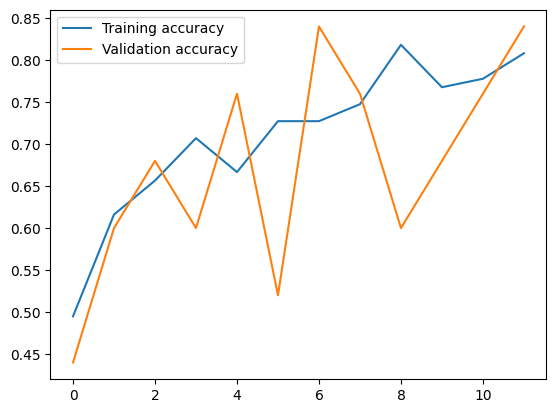

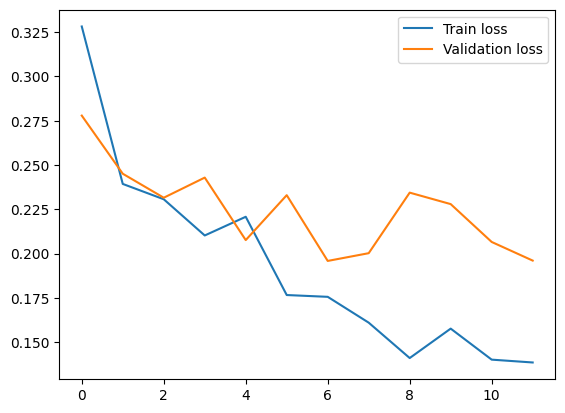

1/1 [==============================] - 0s 54ms/step


AttributeError: 'NoneType' object has no attribute 'inverse_transform'

In [40]:
model = grid_search(params, x_train, y_train, hold_out_val)
test_model(model, x_test, y_test)

# Monks 2

In [21]:
x_train, y_train, x_test, y_test = load_dataset("monks2", True)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

Loaded ./../data/monks-2 dataset
(169, 17) (169,)
(432, 17) (432,)


In [22]:
'''params = {
    "task": "classification",
    "trials_train": 5,
    "trials_test": 10,
    "initialization": {
        "type": "uniform",
        "min": -0.5,
        "max": 0.5
    },
    "early_stopping": {
        "monitor": "val_loss",
        "patience": 20,
        "delta": 0.00
    },
    "max_epochs": [500],
    "learning_rate": [0.1],
    "batch_size": [None],
    "momentum": [0.8],
    "nesterov": False,
    "learning_rate_decay": None,
    "regularization": [
        {
            "type": None
        }
    ],
    "layers": [
        {
            "activations": ["relu"],
            "units": [8],
        },
    ]
}'''

'params = {\n    "task": "classification",\n    "trials_train": 5,\n    "trials_test": 10,\n    "initialization": {\n        "type": "uniform",\n        "min": -0.5,\n        "max": 0.5\n    },\n    "early_stopping": {\n        "monitor": "val_loss",\n        "patience": 20,\n        "delta": 0.00\n    },\n    "max_epochs": [500],\n    "learning_rate": [0.1],\n    "batch_size": [None],\n    "momentum": [0.8],\n    "nesterov": False,\n    "learning_rate_decay": None,\n    "regularization": [\n        {\n            "type": None\n        }\n    ],\n    "layers": [\n        {\n            "activations": ["relu"],\n            "units": [8],\n        },\n    ]\n}'

Testing configuration 1/25:
{'batch_size': None, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.7, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}

Executing fold 1/5


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.31s/it]


Fold 1/5 median val_loss: 0.29399940371513367, std val_loss 0.0
Fold 1/5 median train_loss: 0.21084758639335632, std train_loss 0.0
Fold 1/5 median val_accuracy: 0.44117647409439087, std val_accuracy 0.0
Fold 1/5 median train_accuracy: 0.6666666865348816, train_accuracy 0.0

Executing fold 2/5


100%|█████████████████████████████████████████████| 1/1 [00:17<00:00, 17.72s/it]


Fold 2/5 median val_loss: 0.0008752470021136105, std val_loss 0.0
Fold 2/5 median train_loss: 0.0006158024189062417, std train_loss 0.0
Fold 2/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 2/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 3/5


100%|█████████████████████████████████████████████| 1/1 [00:16<00:00, 16.38s/it]


Fold 3/5 median val_loss: 0.00065045669907704, std val_loss 0.0
Fold 3/5 median train_loss: 0.0005927648162469268, std train_loss 0.0
Fold 3/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 3/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 4/5


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.58s/it]


Fold 4/5 median val_loss: 0.21775472164154053, std val_loss 0.0
Fold 4/5 median train_loss: 0.21090388298034668, std train_loss 0.0
Fold 4/5 median val_accuracy: 0.6470588445663452, std val_accuracy 0.0
Fold 4/5 median train_accuracy: 0.6962962746620178, train_accuracy 0.0

Executing fold 5/5


100%|█████████████████████████████████████████████| 1/1 [00:16<00:00, 16.15s/it]


Fold 5/5 median val_loss: 0.0015612163115292788, std val_loss 0.0
Fold 5/5 median train_loss: 0.0010630411561578512, std train_loss 0.0
Fold 5/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 5/5 median train_accuracy: 1.0, train_accuracy 0.0

Mean val_loss: 0.10296820907387882, std val_loss: 0.127156702009947
Mean train_loss: 0.08480461555300281, std train_loss: 0.1029367758265964
Mean val_accuracy: 0.8176470637321472, std val_accuracy: 0.23263199499504894
Mean train_accuracy: 0.8176470637321472, std train_accuracy: 0.15632262337128225



Testing configuration 2/25:
{'batch_size': None, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.75, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}

Executing fold 1

100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.12s/it]


Fold 1/5 median val_loss: 0.26127132773399353, std val_loss 0.0
Fold 1/5 median train_loss: 0.22025160491466522, std train_loss 0.0
Fold 1/5 median val_accuracy: 0.5588235259056091, std val_accuracy 0.0
Fold 1/5 median train_accuracy: 0.6666666865348816, train_accuracy 0.0

Executing fold 2/5


100%|█████████████████████████████████████████████| 1/1 [00:15<00:00, 15.69s/it]


Fold 2/5 median val_loss: 0.0006874179816804826, std val_loss 0.0
Fold 2/5 median train_loss: 0.0004864561778958887, std train_loss 0.0
Fold 2/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 2/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 3/5


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.00s/it]


Fold 3/5 median val_loss: 0.2600952684879303, std val_loss 0.0
Fold 3/5 median train_loss: 0.2127179503440857, std train_loss 0.0
Fold 3/5 median val_accuracy: 0.6176470518112183, std val_accuracy 0.0
Fold 3/5 median train_accuracy: 0.6962962746620178, train_accuracy 0.0

Executing fold 4/5


100%|█████████████████████████████████████████████| 1/1 [00:19<00:00, 19.27s/it]


Fold 4/5 median val_loss: 0.0010812472319230437, std val_loss 0.0
Fold 4/5 median train_loss: 0.0006701842648908496, std train_loss 0.0
Fold 4/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 4/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 5/5


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.32s/it]


Fold 5/5 median val_loss: 0.22593562304973602, std val_loss 0.0
Fold 5/5 median train_loss: 0.2234649658203125, std train_loss 0.0
Fold 5/5 median val_accuracy: 0.6666666865348816, std val_accuracy 0.0
Fold 5/5 median train_accuracy: 0.6397058963775635, train_accuracy 0.0

Mean val_loss: 0.14981417689705268, std val_loss: 0.12226149417614357
Mean train_loss: 0.13151823230437004, std train_loss: 0.1069689164751881
Mean val_accuracy: 0.7686274528503418, std val_accuracy: 0.19197670602239367
Mean train_accuracy: 0.7686274528503418, std train_accuracy: 0.16384444465683481



Testing configuration 3/25:
{'batch_size': None, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.8, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'unit

100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.00s/it]


Fold 1/5 median val_loss: 0.25702595710754395, std val_loss 0.0
Fold 1/5 median train_loss: 0.21623726189136505, std train_loss 0.0
Fold 1/5 median val_accuracy: 0.6176470518112183, std val_accuracy 0.0
Fold 1/5 median train_accuracy: 0.6888889074325562, train_accuracy 0.0

Executing fold 2/5


100%|█████████████████████████████████████████████| 1/1 [00:17<00:00, 17.69s/it]


Fold 2/5 median val_loss: 0.0005313455476425588, std val_loss 0.0
Fold 2/5 median train_loss: 0.0003118070017080754, std train_loss 0.0
Fold 2/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 2/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 3/5


100%|█████████████████████████████████████████████| 1/1 [00:16<00:00, 16.85s/it]


Fold 3/5 median val_loss: 0.0005212391261011362, std val_loss 0.0
Fold 3/5 median train_loss: 0.0003308849409222603, std train_loss 0.0
Fold 3/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 3/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 4/5


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.27s/it]


Fold 4/5 median val_loss: 0.23590371012687683, std val_loss 0.0
Fold 4/5 median train_loss: 0.21778389811515808, std train_loss 0.0
Fold 4/5 median val_accuracy: 0.6470588445663452, std val_accuracy 0.0
Fold 4/5 median train_accuracy: 0.644444465637207, train_accuracy 0.0

Executing fold 5/5


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.11s/it]


Fold 5/5 median val_loss: 0.27423545718193054, std val_loss 0.0
Fold 5/5 median train_loss: 0.2179512083530426, std train_loss 0.0
Fold 5/5 median val_accuracy: 0.5454545617103577, std val_accuracy 0.0
Fold 5/5 median train_accuracy: 0.6397058963775635, train_accuracy 0.0

Mean val_loss: 0.153643541818019, std val_loss: 0.1256080040131582
Mean train_loss: 0.1305230120604392, std train_loss: 0.10631089525807068
Mean val_accuracy: 0.7620320916175842, std val_accuracy: 0.19709346237656408
Mean train_accuracy: 0.7620320916175842, std train_accuracy: 0.16857759199855643



Testing configuration 4/25:
{'batch_size': None, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.85, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_

100%|█████████████████████████████████████████████| 1/1 [00:16<00:00, 16.22s/it]


Fold 1/5 median val_loss: 0.0006332308985292912, std val_loss 0.0
Fold 1/5 median train_loss: 0.0004016715392936021, std train_loss 0.0
Fold 1/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 1/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 2/5


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.36s/it]


Fold 2/5 median val_loss: 0.2680502235889435, std val_loss 0.0
Fold 2/5 median train_loss: 0.2025691270828247, std train_loss 0.0
Fold 2/5 median val_accuracy: 0.529411792755127, std val_accuracy 0.0
Fold 2/5 median train_accuracy: 0.7333333492279053, train_accuracy 0.0

Executing fold 3/5


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.33s/it]


Fold 3/5 median val_loss: 0.25991079211235046, std val_loss 0.0
Fold 3/5 median train_loss: 0.20919430255889893, std train_loss 0.0
Fold 3/5 median val_accuracy: 0.5882353186607361, std val_accuracy 0.0
Fold 3/5 median train_accuracy: 0.6814814805984497, train_accuracy 0.0

Executing fold 4/5


100%|█████████████████████████████████████████████| 1/1 [00:15<00:00, 15.74s/it]


Fold 4/5 median val_loss: 0.00025581399677321315, std val_loss 0.0
Fold 4/5 median train_loss: 0.00021426785679068416, std train_loss 0.0
Fold 4/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 4/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 5/5


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.20s/it]


Fold 5/5 median val_loss: 0.2428443729877472, std val_loss 0.0
Fold 5/5 median train_loss: 0.21455618739128113, std train_loss 0.0
Fold 5/5 median val_accuracy: 0.5454545617103577, std val_accuracy 0.0
Fold 5/5 median train_accuracy: 0.6102941036224365, train_accuracy 0.0

Mean val_loss: 0.15433888671686874, std val_loss: 0.1259173843212475
Mean train_loss: 0.1253871112858178, std train_loss: 0.1021972933945062
Mean val_accuracy: 0.7326203346252441, std val_accuracy: 0.21916000629070537
Mean train_accuracy: 0.7326203346252441, std train_accuracy: 0.16392273617709766



Testing configuration 5/25:
{'batch_size': None, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.9, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_

100%|█████████████████████████████████████████████| 1/1 [00:15<00:00, 15.65s/it]


Fold 1/5 median val_loss: 0.0004472895816434175, std val_loss 0.0
Fold 1/5 median train_loss: 0.00027271799626760185, std train_loss 0.0
Fold 1/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 1/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 2/5


100%|█████████████████████████████████████████████| 1/1 [00:16<00:00, 16.38s/it]


Fold 2/5 median val_loss: 0.0007289788918569684, std val_loss 0.0
Fold 2/5 median train_loss: 0.00013228689203970134, std train_loss 0.0
Fold 2/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 2/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 3/5


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.05s/it]


Fold 3/5 median val_loss: 0.26541048288345337, std val_loss 0.0
Fold 3/5 median train_loss: 0.17693692445755005, std train_loss 0.0
Fold 3/5 median val_accuracy: 0.5, std val_accuracy 0.0
Fold 3/5 median train_accuracy: 0.6888889074325562, train_accuracy 0.0

Executing fold 4/5


100%|█████████████████████████████████████████████| 1/1 [00:15<00:00, 15.47s/it]


Fold 4/5 median val_loss: 0.00023703323677182198, std val_loss 0.0
Fold 4/5 median train_loss: 0.00012592950952239335, std train_loss 0.0
Fold 4/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 4/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 5/5


100%|█████████████████████████████████████████████| 1/1 [00:16<00:00, 16.65s/it]


Fold 5/5 median val_loss: 0.0001476373872719705, std val_loss 0.0
Fold 5/5 median train_loss: 0.0001231677015312016, std train_loss 0.0
Fold 5/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 5/5 median train_accuracy: 1.0, train_accuracy 0.0

Mean val_loss: 0.05339428439619951, std val_loss: 0.10600828821678501
Mean train_loss: 0.03551820531138219, std train_loss: 0.07070938211756718
Mean val_accuracy: 0.9, std val_accuracy: 0.2
Mean train_accuracy: 0.9, std train_accuracy: 0.12444443702697754



Testing configuration 6/25:
{'batch_size': None, 'learning_rate': 0.15, 'max_epochs': 500, 'momentum': 0.7, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}

Executing fold 1/5


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.33s/it]


Fold 1/5 median val_loss: 0.3006388545036316, std val_loss 0.0
Fold 1/5 median train_loss: 0.19392263889312744, std train_loss 0.0
Fold 1/5 median val_accuracy: 0.44117647409439087, std val_accuracy 0.0
Fold 1/5 median train_accuracy: 0.6740740537643433, train_accuracy 0.0

Executing fold 2/5


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.43s/it]


Fold 2/5 median val_loss: 0.25217893719673157, std val_loss 0.0
Fold 2/5 median train_loss: 0.21429145336151123, std train_loss 0.0
Fold 2/5 median val_accuracy: 0.5882353186607361, std val_accuracy 0.0
Fold 2/5 median train_accuracy: 0.6592592597007751, train_accuracy 0.0

Executing fold 3/5


100%|█████████████████████████████████████████████| 1/1 [00:16<00:00, 16.85s/it]


Fold 3/5 median val_loss: 0.00799532514065504, std val_loss 0.0
Fold 3/5 median train_loss: 0.00038896864862181246, std train_loss 0.0
Fold 3/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 3/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 4/5


100%|█████████████████████████████████████████████| 1/1 [00:15<00:00, 15.75s/it]


Fold 4/5 median val_loss: 0.0009411273058503866, std val_loss 0.0
Fold 4/5 median train_loss: 0.00033247796818614006, std train_loss 0.0
Fold 4/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 4/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 5/5


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.09s/it]


Fold 5/5 median val_loss: 0.2776530683040619, std val_loss 0.0
Fold 5/5 median train_loss: 0.2029910534620285, std train_loss 0.0
Fold 5/5 median val_accuracy: 0.4848484992980957, std val_accuracy 0.0
Fold 5/5 median train_accuracy: 0.7058823704719543, train_accuracy 0.0

Mean val_loss: 0.1678814624901861, std val_loss: 0.13432278082818322
Mean train_loss: 0.12238531846669502, std train_loss: 0.09984148997478381
Mean val_accuracy: 0.7028520584106446, std val_accuracy: 0.24727735789007113
Mean train_accuracy: 0.7028520584106446, std train_accuracy: 0.15761716539131604



Testing configuration 7/25:
{'batch_size': None, 'learning_rate': 0.15, 'max_epochs': 500, 'momentum': 0.75, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'uni

100%|█████████████████████████████████████████████| 1/1 [00:19<00:00, 19.18s/it]


Fold 1/5 median val_loss: 0.0004432901623658836, std val_loss 0.0
Fold 1/5 median train_loss: 0.0003029723302461207, std train_loss 0.0
Fold 1/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 1/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 2/5


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.47s/it]


Fold 2/5 median val_loss: 0.30193856358528137, std val_loss 0.0
Fold 2/5 median train_loss: 0.19588501751422882, std train_loss 0.0
Fold 2/5 median val_accuracy: 0.529411792755127, std val_accuracy 0.0
Fold 2/5 median train_accuracy: 0.7185184955596924, train_accuracy 0.0

Executing fold 3/5


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.72s/it]


Fold 3/5 median val_loss: 0.21186460554599762, std val_loss 0.0
Fold 3/5 median train_loss: 0.2008005976676941, std train_loss 0.0
Fold 3/5 median val_accuracy: 0.7352941036224365, std val_accuracy 0.0
Fold 3/5 median train_accuracy: 0.6888889074325562, train_accuracy 0.0

Executing fold 4/5


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.35s/it]


Fold 4/5 median val_loss: 0.2708897292613983, std val_loss 0.0
Fold 4/5 median train_loss: 0.20835033059120178, std train_loss 0.0
Fold 4/5 median val_accuracy: 0.5, std val_accuracy 0.0
Fold 4/5 median train_accuracy: 0.6962962746620178, train_accuracy 0.0

Executing fold 5/5


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.54s/it]


Fold 5/5 median val_loss: 0.2560048997402191, std val_loss 0.0
Fold 5/5 median train_loss: 0.2168726623058319, std train_loss 0.0
Fold 5/5 median val_accuracy: 0.5151515007019043, std val_accuracy 0.0
Fold 5/5 median train_accuracy: 0.6764705777168274, train_accuracy 0.0

Mean val_loss: 0.20822821765905247, std val_loss: 0.107868906300432
Mean train_loss: 0.16444231608184054, std train_loss: 0.0823761460906839
Mean val_accuracy: 0.6559714794158935, std val_accuracy: 0.1922615014869923
Mean train_accuracy: 0.6559714794158935, std train_accuracy: 0.1227470730206194



Testing configuration 8/25:
{'batch_size': None, 'learning_rate': 0.15, 'max_epochs': 500, 'momentum': 0.8, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1'

100%|█████████████████████████████████████████████| 1/1 [00:17<00:00, 17.48s/it]


Fold 1/5 median val_loss: 0.00021966139320284128, std val_loss 0.0
Fold 1/5 median train_loss: 0.00017673485854174942, std train_loss 0.0
Fold 1/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 1/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 2/5


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.23s/it]


Fold 2/5 median val_loss: 0.2613089382648468, std val_loss 0.0
Fold 2/5 median train_loss: 0.2195444107055664, std train_loss 0.0
Fold 2/5 median val_accuracy: 0.5882353186607361, std val_accuracy 0.0
Fold 2/5 median train_accuracy: 0.6296296119689941, train_accuracy 0.0

Executing fold 3/5


100%|█████████████████████████████████████████████| 1/1 [00:16<00:00, 16.52s/it]


Fold 3/5 median val_loss: 0.00032113579800352454, std val_loss 0.0
Fold 3/5 median train_loss: 0.0001907527621369809, std train_loss 0.0
Fold 3/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 3/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 4/5


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.13s/it]


Fold 4/5 median val_loss: 0.29783639311790466, std val_loss 0.0
Fold 4/5 median train_loss: 0.17364610731601715, std train_loss 0.0
Fold 4/5 median val_accuracy: 0.44117647409439087, std val_accuracy 0.0
Fold 4/5 median train_accuracy: 0.7407407164573669, train_accuracy 0.0

Executing fold 5/5


100%|█████████████████████████████████████████████| 1/1 [00:15<00:00, 15.91s/it]


Fold 5/5 median val_loss: 0.00021105952328070998, std val_loss 0.0
Fold 5/5 median train_loss: 0.00018305459525436163, std train_loss 0.0
Fold 5/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 5/5 median train_accuracy: 1.0, train_accuracy 0.0

Mean val_loss: 0.1119794376194477, std val_loss: 0.1373259640127798
Mean train_loss: 0.07874821204750333, std train_loss: 0.09731024148102682
Mean val_accuracy: 0.8058823585510254, std val_accuracy: 0.24225011549860578
Mean train_accuracy: 0.8058823585510254, std train_accuracy: 0.15817894661938522



Testing configuration 9/25:
{'batch_size': None, 'learning_rate': 0.15, 'max_epochs': 500, 'momentum': 0.85, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}

Executing fo

100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.14s/it]


Fold 1/5 median val_loss: 0.2664097845554352, std val_loss 0.0
Fold 1/5 median train_loss: 0.1928662359714508, std train_loss 0.0
Fold 1/5 median val_accuracy: 0.529411792755127, std val_accuracy 0.0
Fold 1/5 median train_accuracy: 0.7037037014961243, train_accuracy 0.0

Executing fold 2/5


100%|█████████████████████████████████████████████| 1/1 [00:17<00:00, 17.43s/it]


Fold 2/5 median val_loss: 0.00028600607765838504, std val_loss 0.0
Fold 2/5 median train_loss: 0.00012963663903065026, std train_loss 0.0
Fold 2/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 2/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 3/5


100%|█████████████████████████████████████████████| 1/1 [00:17<00:00, 17.16s/it]


Fold 3/5 median val_loss: 0.001044132630340755, std val_loss 0.0
Fold 3/5 median train_loss: 0.0003740855900105089, std train_loss 0.0
Fold 3/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 3/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 4/5


100%|█████████████████████████████████████████████| 1/1 [00:15<00:00, 15.56s/it]


Fold 4/5 median val_loss: 0.00020213167590554804, std val_loss 0.0
Fold 4/5 median train_loss: 0.00013566120469477028, std train_loss 0.0
Fold 4/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 4/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 5/5


100%|█████████████████████████████████████████████| 1/1 [00:15<00:00, 15.23s/it]


Fold 5/5 median val_loss: 0.00015605511725880206, std val_loss 0.0
Fold 5/5 median train_loss: 0.00014518034004140645, std train_loss 0.0
Fold 5/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 5/5 median train_accuracy: 1.0, train_accuracy 0.0

Mean val_loss: 0.053619622011319736, std val_loss: 0.10639557435018583
Mean train_loss: 0.03873015994904563, std train_loss: 0.07706809295211926
Mean val_accuracy: 0.9058823585510254, std val_accuracy: 0.18823528289794922
Mean train_accuracy: 0.9058823585510254, std train_accuracy: 0.11851851940155028



Testing configuration 10/25:
{'batch_size': None, 'learning_rate': 0.15, 'max_epochs': 500, 'momentum': 0.9, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}

Executing

100%|█████████████████████████████████████████████| 1/1 [00:15<00:00, 15.18s/it]


Fold 1/5 median val_loss: 0.00013303698506206274, std val_loss 0.0
Fold 1/5 median train_loss: 7.818144513294101e-05, std train_loss 0.0
Fold 1/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 1/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 2/5


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.11s/it]


Fold 2/5 median val_loss: 0.24334843456745148, std val_loss 0.0
Fold 2/5 median train_loss: 0.19173648953437805, std train_loss 0.0
Fold 2/5 median val_accuracy: 0.7058823704719543, std val_accuracy 0.0
Fold 2/5 median train_accuracy: 0.6962962746620178, train_accuracy 0.0

Executing fold 3/5


100%|█████████████████████████████████████████████| 1/1 [00:15<00:00, 15.13s/it]


Fold 3/5 median val_loss: 9.875027171801776e-05, std val_loss 0.0
Fold 3/5 median train_loss: 8.961334970081225e-05, std train_loss 0.0
Fold 3/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 3/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 4/5


100%|█████████████████████████████████████████████| 1/1 [00:15<00:00, 15.51s/it]


Fold 4/5 median val_loss: 0.00018682361405808479, std val_loss 0.0
Fold 4/5 median train_loss: 7.828432717360556e-05, std train_loss 0.0
Fold 4/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 4/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 5/5


100%|█████████████████████████████████████████████| 1/1 [00:14<00:00, 14.86s/it]


Fold 5/5 median val_loss: 0.00023277169384527951, std val_loss 0.0
Fold 5/5 median train_loss: 7.981441012816504e-05, std train_loss 0.0
Fold 5/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 5/5 median train_accuracy: 1.0, train_accuracy 0.0

Mean val_loss: 0.048799963426426986, std val_loss: 0.09727424632502268
Mean train_loss: 0.038412476613302715, std train_loss: 0.07666200657795982
Mean val_accuracy: 0.9411764740943909, std val_accuracy: 0.11764705181121826
Mean train_accuracy: 0.9411764740943909, std train_accuracy: 0.12148149013519287



Testing configuration 11/25:
{'batch_size': None, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.7, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}

Executing 

100%|█████████████████████████████████████████████| 1/1 [00:16<00:00, 16.25s/it]


Fold 1/5 median val_loss: 0.0005426784628070891, std val_loss 0.0
Fold 1/5 median train_loss: 0.00021501543233171105, std train_loss 0.0
Fold 1/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 1/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 2/5


100%|█████████████████████████████████████████████| 1/1 [00:15<00:00, 15.19s/it]


Fold 2/5 median val_loss: 0.00041614146903157234, std val_loss 0.0
Fold 2/5 median train_loss: 0.0002858170191757381, std train_loss 0.0
Fold 2/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 2/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 3/5


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.24s/it]


Fold 3/5 median val_loss: 0.25446975231170654, std val_loss 0.0
Fold 3/5 median train_loss: 0.18558365106582642, std train_loss 0.0
Fold 3/5 median val_accuracy: 0.5, std val_accuracy 0.0
Fold 3/5 median train_accuracy: 0.7259259223937988, train_accuracy 0.0

Executing fold 4/5


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.30s/it]


Fold 4/5 median val_loss: 0.32185301184654236, std val_loss 0.0
Fold 4/5 median train_loss: 0.20002293586730957, std train_loss 0.0
Fold 4/5 median val_accuracy: 0.44117647409439087, std val_accuracy 0.0
Fold 4/5 median train_accuracy: 0.6888889074325562, train_accuracy 0.0

Executing fold 5/5


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.74s/it]


Fold 5/5 median val_loss: 0.21066513657569885, std val_loss 0.0
Fold 5/5 median train_loss: 0.20313461124897003, std train_loss 0.0
Fold 5/5 median val_accuracy: 0.6666666865348816, std val_accuracy 0.0
Fold 5/5 median train_accuracy: 0.6470588445663452, train_accuracy 0.0

Mean val_loss: 0.15758934413315728, std val_loss: 0.13308078493664854
Mean train_loss: 0.11784840612672269, std train_loss: 0.09620086329459852
Mean val_accuracy: 0.7215686321258545, std val_accuracy: 0.23907099275732852
Mean train_accuracy: 0.7215686321258545, std train_accuracy: 0.15521467106788017



Testing configuration 12/25:
{'batch_size': None, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.75, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', '

100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.16s/it]


Fold 1/5 median val_loss: 0.2355269491672516, std val_loss 0.0
Fold 1/5 median train_loss: 0.2256850302219391, std train_loss 0.0
Fold 1/5 median val_accuracy: 0.5882353186607361, std val_accuracy 0.0
Fold 1/5 median train_accuracy: 0.644444465637207, train_accuracy 0.0

Executing fold 2/5


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.41s/it]


Fold 2/5 median val_loss: 0.20203019678592682, std val_loss 0.0
Fold 2/5 median train_loss: 0.05978717282414436, std train_loss 0.0
Fold 2/5 median val_accuracy: 0.6764705777168274, std val_accuracy 0.0
Fold 2/5 median train_accuracy: 0.9481481313705444, train_accuracy 0.0

Executing fold 3/5


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.52s/it]


Fold 3/5 median val_loss: 0.281777560710907, std val_loss 0.0
Fold 3/5 median train_loss: 0.19734647870063782, std train_loss 0.0
Fold 3/5 median val_accuracy: 0.47058823704719543, std val_accuracy 0.0
Fold 3/5 median train_accuracy: 0.7037037014961243, train_accuracy 0.0

Executing fold 4/5


100%|█████████████████████████████████████████████| 1/1 [00:19<00:00, 19.81s/it]


Fold 4/5 median val_loss: 0.00018453702796250582, std val_loss 0.0
Fold 4/5 median train_loss: 0.00016855145804584026, std train_loss 0.0
Fold 4/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 4/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 5/5


100%|█████████████████████████████████████████████| 1/1 [00:18<00:00, 18.39s/it]


Fold 5/5 median val_loss: 0.00020618260896299034, std val_loss 0.0
Fold 5/5 median train_loss: 0.0001630501647014171, std train_loss 0.0
Fold 5/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 5/5 median train_accuracy: 1.0, train_accuracy 0.0

Mean val_loss: 0.14394508526020217, std val_loss: 0.12007237536580248
Mean train_loss: 0.09663005667389371, std train_loss: 0.09671306766624005
Mean val_accuracy: 0.7470588266849518, std val_accuracy: 0.21661120416272986
Mean train_accuracy: 0.7470588266849518, std train_accuracy: 0.1535318018546035



Testing configuration 13/25:
{'batch_size': None, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.8, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}

Executing fol

100%|█████████████████████████████████████████████| 1/1 [00:19<00:00, 19.35s/it]


Fold 1/5 median val_loss: 0.0001964510593097657, std val_loss 0.0
Fold 1/5 median train_loss: 0.00013953207235317677, std train_loss 0.0
Fold 1/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 1/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 2/5


100%|█████████████████████████████████████████████| 1/1 [00:17<00:00, 17.45s/it]


Fold 2/5 median val_loss: 0.0003246227279305458, std val_loss 0.0
Fold 2/5 median train_loss: 0.00016037076420616359, std train_loss 0.0
Fold 2/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 2/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 3/5


100%|█████████████████████████████████████████████| 1/1 [00:16<00:00, 16.88s/it]


Fold 3/5 median val_loss: 0.000245028204517439, std val_loss 0.0
Fold 3/5 median train_loss: 0.0001322390598943457, std train_loss 0.0
Fold 3/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 3/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 4/5


100%|█████████████████████████████████████████████| 1/1 [00:18<00:00, 18.09s/it]


Fold 4/5 median val_loss: 0.00012732170580420643, std val_loss 0.0
Fold 4/5 median train_loss: 0.00012007349141640589, std train_loss 0.0
Fold 4/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 4/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 5/5


100%|█████████████████████████████████████████████| 1/1 [00:17<00:00, 17.26s/it]


Fold 5/5 median val_loss: 0.00017832333105616271, std val_loss 0.0
Fold 5/5 median train_loss: 0.00012124922795919701, std train_loss 0.0
Fold 5/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 5/5 median train_accuracy: 1.0, train_accuracy 0.0

Mean val_loss: 0.00021434940572362393, std val_loss: 6.677341342112614e-05
Mean train_loss: 0.00013469292316585778, std train_loss: 1.4719042467430379e-05
Mean val_accuracy: 1.0, std val_accuracy: 0.0
Mean train_accuracy: 1.0, std train_accuracy: 0.0



Testing configuration 14/25:
{'batch_size': None, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.85, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}

Executing fold 1/5


100%|█████████████████████████████████████████████| 1/1 [00:17<00:00, 17.59s/it]


Fold 1/5 median val_loss: 9.070783562492579e-05, std val_loss 0.0
Fold 1/5 median train_loss: 8.609663200331852e-05, std train_loss 0.0
Fold 1/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 1/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 2/5


100%|█████████████████████████████████████████████| 1/1 [00:16<00:00, 16.52s/it]


Fold 2/5 median val_loss: 0.00043279066449031234, std val_loss 0.0
Fold 2/5 median train_loss: 9.46432410273701e-05, std train_loss 0.0
Fold 2/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 2/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 3/5


100%|█████████████████████████████████████████████| 1/1 [00:15<00:00, 15.87s/it]


Fold 3/5 median val_loss: 0.00017825036775320768, std val_loss 0.0
Fold 3/5 median train_loss: 0.00011833370808744803, std train_loss 0.0
Fold 3/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 3/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 4/5


100%|█████████████████████████████████████████████| 1/1 [00:15<00:00, 15.97s/it]


Fold 4/5 median val_loss: 0.00025827507488429546, std val_loss 0.0
Fold 4/5 median train_loss: 8.889457967597991e-05, std train_loss 0.0
Fold 4/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 4/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 5/5


100%|█████████████████████████████████████████████| 1/1 [00:15<00:00, 15.79s/it]


Fold 5/5 median val_loss: 0.00012111632531741634, std val_loss 0.0
Fold 5/5 median train_loss: 8.644502668175846e-05, std train_loss 0.0
Fold 5/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 5/5 median train_accuracy: 1.0, train_accuracy 0.0

Mean val_loss: 0.0002162280536140315, std val_loss: 0.00012240195017580288
Mean train_loss: 9.4882637495175e-05, std train_loss: 1.2118201415888496e-05
Mean val_accuracy: 1.0, std val_accuracy: 0.0
Mean train_accuracy: 1.0, std train_accuracy: 0.0



Testing configuration 15/25:
{'batch_size': None, 'learning_rate': 0.2, 'max_epochs': 500, 'momentum': 0.9, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}

Executing fold 1/5


100%|█████████████████████████████████████████████| 1/1 [00:15<00:00, 15.55s/it]


Fold 1/5 median val_loss: 0.0002437205403111875, std val_loss 0.0
Fold 1/5 median train_loss: 7.810716488165781e-05, std train_loss 0.0
Fold 1/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 1/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 2/5


100%|█████████████████████████████████████████████| 1/1 [00:15<00:00, 15.51s/it]


Fold 2/5 median val_loss: 5.4598789574811235e-05, std val_loss 0.0
Fold 2/5 median train_loss: 4.8533645895076916e-05, std train_loss 0.0
Fold 2/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 2/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 3/5


100%|█████████████████████████████████████████████| 1/1 [00:16<00:00, 16.44s/it]


Fold 3/5 median val_loss: 0.0001788741210475564, std val_loss 0.0
Fold 3/5 median train_loss: 5.5991557019297034e-05, std train_loss 0.0
Fold 3/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 3/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 4/5


100%|█████████████████████████████████████████████| 1/1 [00:17<00:00, 17.63s/it]


Fold 4/5 median val_loss: 0.0002168643695767969, std val_loss 0.0
Fold 4/5 median train_loss: 9.732128091854975e-05, std train_loss 0.0
Fold 4/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 4/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 5/5


100%|█████████████████████████████████████████████| 1/1 [00:17<00:00, 17.70s/it]


Fold 5/5 median val_loss: 0.00011173680104548112, std val_loss 0.0
Fold 5/5 median train_loss: 6.257685890886933e-05, std train_loss 0.0
Fold 5/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 5/5 median train_accuracy: 1.0, train_accuracy 0.0

Mean val_loss: 0.00016115892431116662, std val_loss: 6.932669593642099e-05
Mean train_loss: 6.850610152469017e-05, std train_loss: 1.7396342760111497e-05
Mean val_accuracy: 1.0, std val_accuracy: 0.0
Mean train_accuracy: 1.0, std train_accuracy: 0.0



Testing configuration 16/25:
{'batch_size': None, 'learning_rate': 0.25, 'max_epochs': 500, 'momentum': 0.7, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}

Executing fold 1/5


100%|█████████████████████████████████████████████| 1/1 [00:16<00:00, 16.22s/it]


Fold 1/5 median val_loss: 0.00022739414998795837, std val_loss 0.0
Fold 1/5 median train_loss: 0.00015479668218176812, std train_loss 0.0
Fold 1/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 1/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 2/5


100%|█████████████████████████████████████████████| 1/1 [00:15<00:00, 15.95s/it]


Fold 2/5 median val_loss: 0.0003152320277877152, std val_loss 0.0
Fold 2/5 median train_loss: 0.00015870973584242165, std train_loss 0.0
Fold 2/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 2/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 3/5


100%|█████████████████████████████████████████████| 1/1 [00:17<00:00, 17.47s/it]


Fold 3/5 median val_loss: 0.0002815792104229331, std val_loss 0.0
Fold 3/5 median train_loss: 0.00016311435319948941, std train_loss 0.0
Fold 3/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 3/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 4/5


100%|█████████████████████████████████████████████| 1/1 [00:16<00:00, 16.34s/it]


Fold 4/5 median val_loss: 0.00016681445413269103, std val_loss 0.0
Fold 4/5 median train_loss: 0.0001550357701489702, std train_loss 0.0
Fold 4/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 4/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 5/5


100%|█████████████████████████████████████████████| 1/1 [00:14<00:00, 14.82s/it]


Fold 5/5 median val_loss: 0.0002148134371964261, std val_loss 0.0
Fold 5/5 median train_loss: 0.00015404412988573313, std train_loss 0.0
Fold 5/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 5/5 median train_accuracy: 1.0, train_accuracy 0.0

Mean val_loss: 0.00024116665590554476, std val_loss: 5.202168363041865e-05
Mean train_loss: 0.0001571401342516765, std train_loss: 3.3958886938394727e-06
Mean val_accuracy: 1.0, std val_accuracy: 0.0
Mean train_accuracy: 1.0, std train_accuracy: 0.0



Testing configuration 17/25:
{'batch_size': None, 'learning_rate': 0.25, 'max_epochs': 500, 'momentum': 0.75, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}

Executing fold 1/5


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.05s/it]


Fold 1/5 median val_loss: 0.2705877423286438, std val_loss 0.0
Fold 1/5 median train_loss: 0.18157610297203064, std train_loss 0.0
Fold 1/5 median val_accuracy: 0.529411792755127, std val_accuracy 0.0
Fold 1/5 median train_accuracy: 0.770370364189148, train_accuracy 0.0

Executing fold 2/5


100%|█████████████████████████████████████████████| 1/1 [00:15<00:00, 15.27s/it]


Fold 2/5 median val_loss: 0.0003143716021440923, std val_loss 0.0
Fold 2/5 median train_loss: 0.00017473481420893222, std train_loss 0.0
Fold 2/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 2/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 3/5


100%|█████████████████████████████████████████████| 1/1 [00:15<00:00, 15.94s/it]


Fold 3/5 median val_loss: 0.00036839256063103676, std val_loss 0.0
Fold 3/5 median train_loss: 0.0001376244763378054, std train_loss 0.0
Fold 3/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 3/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 4/5


100%|█████████████████████████████████████████████| 1/1 [00:15<00:00, 15.22s/it]


Fold 4/5 median val_loss: 0.00014013098552823067, std val_loss 0.0
Fold 4/5 median train_loss: 0.00011938477837247774, std train_loss 0.0
Fold 4/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 4/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 5/5


100%|█████████████████████████████████████████████| 1/1 [00:17<00:00, 17.24s/it]


Fold 5/5 median val_loss: 0.00018277215713169426, std val_loss 0.0
Fold 5/5 median train_loss: 0.00013198713713791221, std train_loss 0.0
Fold 5/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 5/5 median train_accuracy: 1.0, train_accuracy 0.0

Mean val_loss: 0.05431868192681577, std val_loss: 0.10813456233056766
Mean train_loss: 0.03642796683561755, std train_loss: 0.07257407040769681
Mean val_accuracy: 0.9058823585510254, std val_accuracy: 0.18823528289794922
Mean train_accuracy: 0.9058823585510254, std train_accuracy: 0.09185185432434081



Testing configuration 18/25:
{'batch_size': None, 'learning_rate': 0.25, 'max_epochs': 500, 'momentum': 0.8, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}

Executing 

100%|█████████████████████████████████████████████| 1/1 [00:16<00:00, 16.89s/it]


Fold 1/5 median val_loss: 0.00016254572256002575, std val_loss 0.0
Fold 1/5 median train_loss: 9.651896834839135e-05, std train_loss 0.0
Fold 1/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 1/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 2/5


100%|█████████████████████████████████████████████| 1/1 [00:15<00:00, 15.90s/it]


Fold 2/5 median val_loss: 0.00018517489661462605, std val_loss 0.0
Fold 2/5 median train_loss: 0.00010266499884892255, std train_loss 0.0
Fold 2/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 2/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 3/5


100%|█████████████████████████████████████████████| 1/1 [00:18<00:00, 18.47s/it]


Fold 3/5 median val_loss: 9.39494275371544e-05, std val_loss 0.0
Fold 3/5 median train_loss: 0.000105833045381587, std train_loss 0.0
Fold 3/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 3/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 4/5


100%|█████████████████████████████████████████████| 1/1 [00:19<00:00, 19.88s/it]


Fold 4/5 median val_loss: 0.0007056747563183308, std val_loss 0.0
Fold 4/5 median train_loss: 0.00017384818056598306, std train_loss 0.0
Fold 4/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 4/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 5/5


100%|█████████████████████████████████████████████| 1/1 [00:20<00:00, 20.35s/it]


Fold 5/5 median val_loss: 0.00015008087211754173, std val_loss 0.0
Fold 5/5 median train_loss: 9.501070599071681e-05, std train_loss 0.0
Fold 5/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 5/5 median train_accuracy: 1.0, train_accuracy 0.0

Mean val_loss: 0.00025948513502953573, std val_loss: 0.0002251114402101203
Mean train_loss: 0.00011477517982712015, std train_loss: 2.9799870307255795e-05
Mean val_accuracy: 1.0, std val_accuracy: 0.0
Mean train_accuracy: 1.0, std train_accuracy: 0.0



Testing configuration 19/25:
{'batch_size': None, 'learning_rate': 0.25, 'max_epochs': 500, 'momentum': 0.85, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}

Executing fold 1/5


100%|█████████████████████████████████████████████| 1/1 [00:22<00:00, 22.82s/it]


Fold 1/5 median val_loss: 0.0001270848442800343, std val_loss 0.0
Fold 1/5 median train_loss: 0.00013020742335356772, std train_loss 0.0
Fold 1/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 1/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 2/5


100%|█████████████████████████████████████████████| 1/1 [00:21<00:00, 21.02s/it]


Fold 2/5 median val_loss: 0.00011390311556169763, std val_loss 0.0
Fold 2/5 median train_loss: 6.712720642099157e-05, std train_loss 0.0
Fold 2/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 2/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 3/5


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.39s/it]


Fold 3/5 median val_loss: 0.24632196128368378, std val_loss 0.0
Fold 3/5 median train_loss: 0.18090198934078217, std train_loss 0.0
Fold 3/5 median val_accuracy: 0.5882353186607361, std val_accuracy 0.0
Fold 3/5 median train_accuracy: 0.7555555701255798, train_accuracy 0.0

Executing fold 4/5


100%|█████████████████████████████████████████████| 1/1 [00:18<00:00, 18.47s/it]


Fold 4/5 median val_loss: 0.0003228158166166395, std val_loss 0.0
Fold 4/5 median train_loss: 0.00013195768406149, std train_loss 0.0
Fold 4/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 4/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 5/5


100%|█████████████████████████████████████████████| 1/1 [00:18<00:00, 18.92s/it]


Fold 5/5 median val_loss: 0.00017161440337076783, std val_loss 0.0
Fold 5/5 median train_loss: 6.611008575418964e-05, std train_loss 0.0
Fold 5/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 5/5 median train_accuracy: 1.0, train_accuracy 0.0

Mean val_loss: 0.04941147589270258, std val_loss: 0.0984552707042109
Mean train_loss: 0.036259478348074484, std train_loss: 0.07232126124520896
Mean val_accuracy: 0.9176470637321472, std val_accuracy: 0.16470587253570557
Mean train_accuracy: 0.9176470637321472, std train_accuracy: 0.09777777194976807



Testing configuration 20/25:
{'batch_size': None, 'learning_rate': 0.25, 'max_epochs': 500, 'momentum': 0.9, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}

Executing f

100%|█████████████████████████████████████████████| 1/1 [00:18<00:00, 18.38s/it]


Fold 1/5 median val_loss: 4.867622919846326e-05, std val_loss 0.0
Fold 1/5 median train_loss: 3.9493599615525454e-05, std train_loss 0.0
Fold 1/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 1/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 2/5


100%|█████████████████████████████████████████████| 1/1 [00:19<00:00, 19.02s/it]


Fold 2/5 median val_loss: 8.812620217213407e-05, std val_loss 0.0
Fold 2/5 median train_loss: 7.632541382918134e-05, std train_loss 0.0
Fold 2/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 2/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 3/5


100%|█████████████████████████████████████████████| 1/1 [00:17<00:00, 17.44s/it]


Fold 3/5 median val_loss: 8.26665636850521e-05, std val_loss 0.0
Fold 3/5 median train_loss: 5.297483585309237e-05, std train_loss 0.0
Fold 3/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 3/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 4/5


100%|█████████████████████████████████████████████| 1/1 [00:17<00:00, 17.09s/it]


Fold 4/5 median val_loss: 4.8644677008269355e-05, std val_loss 0.0
Fold 4/5 median train_loss: 3.895139889209531e-05, std train_loss 0.0
Fold 4/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 4/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 5/5


100%|█████████████████████████████████████████████| 1/1 [00:16<00:00, 16.08s/it]


Fold 5/5 median val_loss: 9.776352817425504e-05, std val_loss 0.0
Fold 5/5 median train_loss: 7.909023406682536e-05, std train_loss 0.0
Fold 5/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 5/5 median train_accuracy: 1.0, train_accuracy 0.0

Mean val_loss: 7.317544004763477e-05, std val_loss: 2.0591990973445037e-05
Mean train_loss: 5.736709645134397e-05, std train_loss: 1.737356765063893e-05
Mean val_accuracy: 1.0, std val_accuracy: 0.0
Mean train_accuracy: 1.0, std train_accuracy: 0.0



Testing configuration 21/25:
{'batch_size': None, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.7, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}

Executing fold 1/5


100%|█████████████████████████████████████████████| 1/1 [00:16<00:00, 16.94s/it]


Fold 1/5 median val_loss: 0.00019682443235069513, std val_loss 0.0
Fold 1/5 median train_loss: 0.00013927579857409, std train_loss 0.0
Fold 1/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 1/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 2/5


100%|█████████████████████████████████████████████| 1/1 [00:16<00:00, 16.64s/it]


Fold 2/5 median val_loss: 0.00014999776612967253, std val_loss 0.0
Fold 2/5 median train_loss: 0.000124380414490588, std train_loss 0.0
Fold 2/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 2/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 3/5


100%|█████████████████████████████████████████████| 1/1 [00:16<00:00, 16.89s/it]


Fold 3/5 median val_loss: 0.00028726362506859004, std val_loss 0.0
Fold 3/5 median train_loss: 0.00023656082339584827, std train_loss 0.0
Fold 3/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 3/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 4/5


100%|█████████████████████████████████████████████| 1/1 [00:17<00:00, 17.01s/it]


Fold 4/5 median val_loss: 0.0003438878047745675, std val_loss 0.0
Fold 4/5 median train_loss: 0.00015046512999106199, std train_loss 0.0
Fold 4/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 4/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 5/5


100%|█████████████████████████████████████████████| 1/1 [00:17<00:00, 17.76s/it]


Fold 5/5 median val_loss: 0.00016798987053334713, std val_loss 0.0
Fold 5/5 median train_loss: 0.00012155775766586885, std train_loss 0.0
Fold 5/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 5/5 median train_accuracy: 1.0, train_accuracy 0.0

Mean val_loss: 0.00022919269977137447, std val_loss: 7.428664487461738e-05
Mean train_loss: 0.0001544479848234914, std train_loss: 4.236602991741561e-05
Mean val_accuracy: 1.0, std val_accuracy: 0.0
Mean train_accuracy: 1.0, std train_accuracy: 0.0



Testing configuration 22/25:
{'batch_size': None, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.75, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}

Executing fold 1/5


100%|█████████████████████████████████████████████| 1/1 [00:16<00:00, 16.78s/it]


Fold 1/5 median val_loss: 0.00015017820987850428, std val_loss 0.0
Fold 1/5 median train_loss: 0.0001827448431868106, std train_loss 0.0
Fold 1/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 1/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 2/5


100%|█████████████████████████████████████████████| 1/1 [00:15<00:00, 15.60s/it]


Fold 2/5 median val_loss: 0.0003770986513700336, std val_loss 0.0
Fold 2/5 median train_loss: 0.00011477585940156132, std train_loss 0.0
Fold 2/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 2/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 3/5


100%|█████████████████████████████████████████████| 1/1 [00:17<00:00, 17.96s/it]


Fold 3/5 median val_loss: 0.0002767942496575415, std val_loss 0.0
Fold 3/5 median train_loss: 0.00010699071572162211, std train_loss 0.0
Fold 3/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 3/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 4/5


100%|█████████████████████████████████████████████| 1/1 [00:15<00:00, 15.85s/it]


Fold 4/5 median val_loss: 0.00012445534230209887, std val_loss 0.0
Fold 4/5 median train_loss: 0.00010288991325069219, std train_loss 0.0
Fold 4/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 4/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 5/5


100%|█████████████████████████████████████████████| 1/1 [00:16<00:00, 16.46s/it]


Fold 5/5 median val_loss: 0.0003306089492980391, std val_loss 0.0
Fold 5/5 median train_loss: 0.00010681022104108706, std train_loss 0.0
Fold 5/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 5/5 median train_accuracy: 1.0, train_accuracy 0.0

Mean val_loss: 0.00025182708050124346, std val_loss: 9.907468036332878e-05
Mean train_loss: 0.00012284231052035467, std train_loss: 3.0198609772797777e-05
Mean val_accuracy: 1.0, std val_accuracy: 0.0
Mean train_accuracy: 1.0, std train_accuracy: 0.0



Testing configuration 23/25:
{'batch_size': None, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.8, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}

Executing fold 1/5


100%|█████████████████████████████████████████████| 1/1 [00:16<00:00, 16.82s/it]


Fold 1/5 median val_loss: 0.00012509415682870895, std val_loss 0.0
Fold 1/5 median train_loss: 7.949215796543285e-05, std train_loss 0.0
Fold 1/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 1/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 2/5


100%|█████████████████████████████████████████████| 1/1 [00:15<00:00, 15.55s/it]


Fold 2/5 median val_loss: 0.0003371358325239271, std val_loss 0.0
Fold 2/5 median train_loss: 8.804831304587424e-05, std train_loss 0.0
Fold 2/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 2/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 3/5


100%|█████████████████████████████████████████████| 1/1 [00:18<00:00, 18.15s/it]


Fold 3/5 median val_loss: 0.0004001618945039809, std val_loss 0.0
Fold 3/5 median train_loss: 8.275911386590451e-05, std train_loss 0.0
Fold 3/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 3/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 4/5


100%|█████████████████████████████████████████████| 1/1 [00:17<00:00, 17.80s/it]


Fold 4/5 median val_loss: 8.55821926961653e-05, std val_loss 0.0
Fold 4/5 median train_loss: 8.293318387586623e-05, std train_loss 0.0
Fold 4/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 4/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 5/5


100%|█████████████████████████████████████████████| 1/1 [00:17<00:00, 17.66s/it]


Fold 5/5 median val_loss: 0.0001339666050625965, std val_loss 0.0
Fold 5/5 median train_loss: 8.052223711274564e-05, std train_loss 0.0
Fold 5/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 5/5 median train_accuracy: 1.0, train_accuracy 0.0

Mean val_loss: 0.00021638813632307574, std val_loss: 0.00012695739027651236
Mean train_loss: 8.27510011731647e-05, std train_loss: 2.9557475439993923e-06
Mean val_accuracy: 1.0, std val_accuracy: 0.0
Mean train_accuracy: 1.0, std train_accuracy: 0.0



Testing configuration 24/25:
{'batch_size': None, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.85, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}

Executing fold 1/5


100%|█████████████████████████████████████████████| 1/1 [00:17<00:00, 17.53s/it]


Fold 1/5 median val_loss: 0.00017195483087562025, std val_loss 0.0
Fold 1/5 median train_loss: 0.00010510304855415598, std train_loss 0.0
Fold 1/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 1/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 2/5


100%|█████████████████████████████████████████████| 1/1 [00:18<00:00, 18.09s/it]


Fold 2/5 median val_loss: 0.00011080800322815776, std val_loss 0.0
Fold 2/5 median train_loss: 5.581590812653303e-05, std train_loss 0.0
Fold 2/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 2/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 3/5


100%|█████████████████████████████████████████████| 1/1 [00:17<00:00, 17.22s/it]


Fold 3/5 median val_loss: 8.69033028720878e-05, std val_loss 0.0
Fold 3/5 median train_loss: 5.319988486007787e-05, std train_loss 0.0
Fold 3/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 3/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 4/5


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.36s/it]


Fold 4/5 median val_loss: 0.23873595893383026, std val_loss 0.0
Fold 4/5 median train_loss: 0.17825984954833984, std train_loss 0.0
Fold 4/5 median val_accuracy: 0.6764705777168274, std val_accuracy 0.0
Fold 4/5 median train_accuracy: 0.770370364189148, train_accuracy 0.0

Executing fold 5/5


100%|█████████████████████████████████████████████| 1/1 [00:16<00:00, 16.62s/it]


Fold 5/5 median val_loss: 0.00024055734684225172, std val_loss 0.0
Fold 5/5 median train_loss: 0.00010994319018209353, std train_loss 0.0
Fold 5/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 5/5 median train_accuracy: 1.0, train_accuracy 0.0

Mean val_loss: 0.04786923648352968, std val_loss: 0.09543337607710801
Mean train_loss: 0.03571678231601254, std train_loss: 0.07127153758092897
Mean val_accuracy: 0.9352941155433655, std val_accuracy: 0.12941176891326903
Mean train_accuracy: 0.9352941155433655, std train_accuracy: 0.09185185432434081



Testing configuration 25/25:
{'batch_size': None, 'learning_rate': 0.3, 'max_epochs': 500, 'momentum': 0.9, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}

Executing f

100%|█████████████████████████████████████████████| 1/1 [00:18<00:00, 18.10s/it]


Fold 1/5 median val_loss: 6.837685214122757e-05, std val_loss 0.0
Fold 1/5 median train_loss: 4.6831195504637435e-05, std train_loss 0.0
Fold 1/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 1/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 2/5


100%|█████████████████████████████████████████████| 1/1 [00:16<00:00, 16.27s/it]


Fold 2/5 median val_loss: 7.107922283466905e-05, std val_loss 0.0
Fold 2/5 median train_loss: 8.49917414598167e-05, std train_loss 0.0
Fold 2/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 2/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 3/5


100%|█████████████████████████████████████████████| 1/1 [00:17<00:00, 17.54s/it]


Fold 3/5 median val_loss: 0.00010907105752266943, std val_loss 0.0
Fold 3/5 median train_loss: 3.2690299121895805e-05, std train_loss 0.0
Fold 3/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 3/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 4/5


100%|█████████████████████████████████████████████| 1/1 [00:18<00:00, 18.09s/it]


Fold 4/5 median val_loss: 0.0004787952930200845, std val_loss 0.0
Fold 4/5 median train_loss: 9.200215572491288e-05, std train_loss 0.0
Fold 4/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 4/5 median train_accuracy: 1.0, train_accuracy 0.0

Executing fold 5/5


100%|█████████████████████████████████████████████| 1/1 [00:18<00:00, 18.26s/it]


Fold 5/5 median val_loss: 0.00011181375157320872, std val_loss 0.0
Fold 5/5 median train_loss: 6.641240906901658e-05, std train_loss 0.0
Fold 5/5 median val_accuracy: 1.0, std val_accuracy 0.0
Fold 5/5 median train_accuracy: 1.0, train_accuracy 0.0

Mean val_loss: 0.00016782723541837187, std val_loss: 0.00015655126210595242
Mean train_loss: 6.458556017605588e-05, std train_loss: 2.237831300858829e-05
Mean val_accuracy: 1.0, std val_accuracy: 0.0
Mean train_accuracy: 1.0, std train_accuracy: 0.0






Best configuration (loss 7.317544004763477e-05):
{'batch_size': None, 'learning_rate': 0.25, 'max_epochs': 500, 'momentum': 0.9, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': None, 'regularization': {'method': None}, 'activations_1': 'relu', 'units_1': 8}


 10%|████▍                                       | 1/10 [00:17<02:34, 17.12s/it]

Trial 1/10 val_mse: 8.172646630555391e-05
Trial 1/10 train_mse: 3.997033491032198e-05
Trial 1/10 val_accuracy: 1.0
Trial 1/10 train_accuracy: 1.0


 20%|████████▊                                   | 2/10 [00:32<02:09, 16.15s/it]

Trial 2/10 val_mse: 0.000146407081047073
Trial 2/10 train_mse: 5.170979420654476e-05
Trial 2/10 val_accuracy: 1.0
Trial 2/10 train_accuracy: 1.0


 30%|█████████████▏                              | 3/10 [00:48<01:51, 15.86s/it]

Trial 3/10 val_mse: 8.548366167815402e-05
Trial 3/10 train_mse: 5.412750397226773e-05
Trial 3/10 val_accuracy: 1.0
Trial 3/10 train_accuracy: 1.0


 40%|█████████████████▌                          | 4/10 [01:03<01:35, 15.84s/it]

Trial 4/10 val_mse: 0.00017878177459351718
Trial 4/10 train_mse: 6.082669278839603e-05
Trial 4/10 val_accuracy: 1.0
Trial 4/10 train_accuracy: 1.0


 50%|██████████████████████                      | 5/10 [01:19<01:19, 15.93s/it]

Trial 5/10 val_mse: 0.00010800154996104538
Trial 5/10 train_mse: 7.12586916051805e-05
Trial 5/10 val_accuracy: 1.0
Trial 5/10 train_accuracy: 1.0


 60%|██████████████████████████▍                 | 6/10 [01:35<01:02, 15.74s/it]

Trial 6/10 val_mse: 6.65658080833964e-05
Trial 6/10 train_mse: 3.792784264078364e-05
Trial 6/10 val_accuracy: 1.0
Trial 6/10 train_accuracy: 1.0


 70%|██████████████████████████████▊             | 7/10 [01:52<00:48, 16.07s/it]

Trial 7/10 val_mse: 6.293417391134426e-05
Trial 7/10 train_mse: 3.979452230851166e-05
Trial 7/10 val_accuracy: 1.0
Trial 7/10 train_accuracy: 1.0


 80%|███████████████████████████████████▏        | 8/10 [02:13<00:35, 17.85s/it]

Trial 8/10 val_mse: 5.467964365379885e-05
Trial 8/10 train_mse: 3.8822116039227694e-05
Trial 8/10 val_accuracy: 1.0
Trial 8/10 train_accuracy: 1.0


 90%|███████████████████████████████████████▌    | 9/10 [02:29<00:17, 17.27s/it]

Trial 9/10 val_mse: 6.572678103111684e-05
Trial 9/10 train_mse: 3.8916721678106114e-05
Trial 9/10 val_accuracy: 1.0
Trial 9/10 train_accuracy: 1.0


100%|███████████████████████████████████████████| 10/10 [02:47<00:00, 16.74s/it]

Trial 10/10 val_mse: 7.381878822343424e-05
Trial 10/10 train_mse: 4.10403918067459e-05
Trial 10/10 val_accuracy: 1.0
Trial 10/10 train_accuracy: 1.0

Median val_mse: 8.172646630555391e-05, std val_mse: 3.84693778557485e-05
Median train_mse: 3.997033491032198e-05, std train_mse: 1.0963972857893669e-05
Median val_accuracy: 1.0, std val_accuracy: 0.0
Median train_accuracy: 1.0, std train_accuracy: 0.0


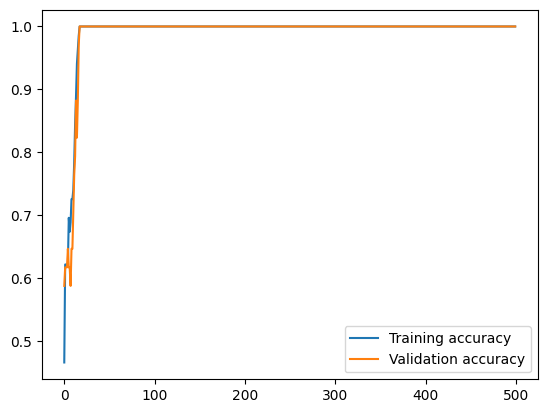

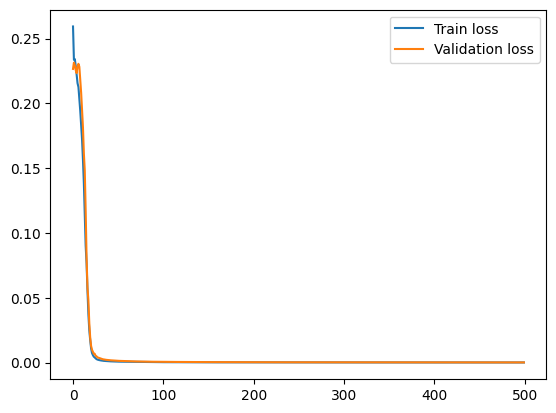

14/14 [==============================] - 0s 1ms/step - loss: 7.1067e-05 - accuracy: 1.0000
[7.106726843630895e-05, 1.0]


In [23]:
model = grid_search(params, x_train, y_train, k_fold_val)
test_model(model, x_test, y_test)

# Monks 3

In [25]:
params = {
    "task": "classification",
    "trials_train": 1,
    "trials_test": 10,
    "initialization": {
        "type": "uniform",
        "min": -0.5,
        "max": 0.5
    },
    "early_stopping": {
        "monitor": "val_loss",
        "patience": 20,
        "delta": 0.0
    },
    "max_epochs": [500],
    "learning_rate": np.linspace(0.1, 0.9, 5).tolist(),
    "batch_size": [None],
    "momentum": np.linspace(0.5, 0.99, 5).tolist(),
    "nesterov": False,
    "learning_rate_decay": {
        "epochs": 50,
        "lr_final": 0.01
    },
    "regularization": [
        {
            "type": "l2",
            "value": [0.000001, 0.00001, 0.0001, 0.001, 0.01],
        }
    ],
    "layers": [
        {
            "activations": ["relu"],
            "units": [16],
        },
    ]
}


k_fold_val = {
    "type": "k-fold",
    "n_folds": 5
}

hold_out_val = {
    "type": "hold-out",
    "val_split": 0.15
}

In [26]:
x_train, y_train, x_test, y_test = load_dataset("monks3", True)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

Loaded ./../data/monks-3 dataset
(122, 17) (122,)
(432, 17) (432,)


Testing configuration 1/125:
{'batch_size': None, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.5, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': {'epochs': 50, 'lr_final': 0.01}, 'regularization': {'method': 'l2', 'value': 1e-06}, 'activations_1': 'relu', 'units_1': 16}


100%|█████████████████████████████████████████████| 1/1 [00:19<00:00, 19.39s/it]


Median val_loss: 0.054011665284633636, std val_loss 0.0
Median train_loss: 0.06380080431699753, std train_loss 0.0
Median val_accuracy: 0.9473684430122375, std val_accuracy 0.0
Median train_accuracy: 0.9320388436317444, train_accuracy 0.0



Testing configuration 2/125:
{'batch_size': None, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.5, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': {'epochs': 50, 'lr_final': 0.01}, 'regularization': {'method': 'l2', 'value': 1e-05}, 'activations_1': 'relu', 'units_1': 16}


100%|█████████████████████████████████████████████| 1/1 [00:17<00:00, 17.38s/it]


Median val_loss: 0.08413194119930267, std val_loss 0.0
Median train_loss: 0.059244196861982346, std train_loss 0.0
Median val_accuracy: 0.8947368264198303, std val_accuracy 0.0
Median train_accuracy: 0.9417475461959839, train_accuracy 0.0



Testing configuration 3/125:
{'batch_size': None, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.5, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': {'epochs': 50, 'lr_final': 0.01}, 'regularization': {'method': 'l2', 'value': 0.0001}, 'activations_1': 'relu', 'units_1': 16}


100%|█████████████████████████████████████████████| 1/1 [00:15<00:00, 15.96s/it]


Median val_loss: 0.09222446382045746, std val_loss 0.0
Median train_loss: 0.053577668964862823, std train_loss 0.0
Median val_accuracy: 0.8947368264198303, std val_accuracy 0.0
Median train_accuracy: 0.9417475461959839, train_accuracy 0.0



Testing configuration 4/125:
{'batch_size': None, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.5, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': {'epochs': 50, 'lr_final': 0.01}, 'regularization': {'method': 'l2', 'value': 0.001}, 'activations_1': 'relu', 'units_1': 16}


100%|█████████████████████████████████████████████| 1/1 [00:14<00:00, 14.93s/it]


Median val_loss: 0.1135716587305069, std val_loss 0.0
Median train_loss: 0.08173388987779617, std train_loss 0.0
Median val_accuracy: 0.8947368264198303, std val_accuracy 0.0
Median train_accuracy: 0.9417475461959839, train_accuracy 0.0



Testing configuration 5/125:
{'batch_size': None, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.5, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': {'epochs': 50, 'lr_final': 0.01}, 'regularization': {'method': 'l2', 'value': 0.01}, 'activations_1': 'relu', 'units_1': 16}


100%|█████████████████████████████████████████████| 1/1 [00:15<00:00, 15.37s/it]


Median val_loss: 0.14966166019439697, std val_loss 0.0
Median train_loss: 0.18446248769760132, std train_loss 0.0
Median val_accuracy: 1.0, std val_accuracy 0.0
Median train_accuracy: 0.9223300814628601, train_accuracy 0.0



Testing configuration 6/125:
{'batch_size': None, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.6225, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': {'epochs': 50, 'lr_final': 0.01}, 'regularization': {'method': 'l2', 'value': 1e-06}, 'activations_1': 'relu', 'units_1': 16}


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.08s/it]


Median val_loss: 0.12591657042503357, std val_loss 0.0
Median train_loss: 0.053366318345069885, std train_loss 0.0
Median val_accuracy: 0.8421052694320679, std val_accuracy 0.0
Median train_accuracy: 0.9514563083648682, train_accuracy 0.0



Testing configuration 7/125:
{'batch_size': None, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.6225, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': {'epochs': 50, 'lr_final': 0.01}, 'regularization': {'method': 'l2', 'value': 1e-05}, 'activations_1': 'relu', 'units_1': 16}


100%|█████████████████████████████████████████████| 1/1 [00:12<00:00, 12.53s/it]


Median val_loss: 0.12066890299320221, std val_loss 0.0
Median train_loss: 0.04668967053294182, std train_loss 0.0
Median val_accuracy: 0.8947368264198303, std val_accuracy 0.0
Median train_accuracy: 0.9611650705337524, train_accuracy 0.0



Testing configuration 8/125:
{'batch_size': None, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.6225, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': {'epochs': 50, 'lr_final': 0.01}, 'regularization': {'method': 'l2', 'value': 0.0001}, 'activations_1': 'relu', 'units_1': 16}


100%|█████████████████████████████████████████████| 1/1 [00:15<00:00, 15.07s/it]


Median val_loss: 0.14139783382415771, std val_loss 0.0
Median train_loss: 0.04866182059049606, std train_loss 0.0
Median val_accuracy: 0.8421052694320679, std val_accuracy 0.0
Median train_accuracy: 0.9514563083648682, train_accuracy 0.0



Testing configuration 9/125:
{'batch_size': None, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.6225, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': {'epochs': 50, 'lr_final': 0.01}, 'regularization': {'method': 'l2', 'value': 0.001}, 'activations_1': 'relu', 'units_1': 16}


100%|█████████████████████████████████████████████| 1/1 [00:17<00:00, 17.41s/it]


Median val_loss: 0.11964346468448639, std val_loss 0.0
Median train_loss: 0.09245224297046661, std train_loss 0.0
Median val_accuracy: 0.9473684430122375, std val_accuracy 0.0
Median train_accuracy: 0.9320388436317444, train_accuracy 0.0



Testing configuration 10/125:
{'batch_size': None, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.6225, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': {'epochs': 50, 'lr_final': 0.01}, 'regularization': {'method': 'l2', 'value': 0.01}, 'activations_1': 'relu', 'units_1': 16}


100%|█████████████████████████████████████████████| 1/1 [00:17<00:00, 17.81s/it]


Median val_loss: 0.16019845008850098, std val_loss 0.0
Median train_loss: 0.16366606950759888, std train_loss 0.0
Median val_accuracy: 0.9473684430122375, std val_accuracy 0.0
Median train_accuracy: 0.9320388436317444, train_accuracy 0.0



Testing configuration 11/125:
{'batch_size': None, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.745, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': {'epochs': 50, 'lr_final': 0.01}, 'regularization': {'method': 'l2', 'value': 1e-06}, 'activations_1': 'relu', 'units_1': 16}


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.88s/it]


Median val_loss: 0.07458046823740005, std val_loss 0.0
Median train_loss: 0.048075947910547256, std train_loss 0.0
Median val_accuracy: 0.9473684430122375, std val_accuracy 0.0
Median train_accuracy: 0.9417475461959839, train_accuracy 0.0



Testing configuration 12/125:
{'batch_size': None, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.745, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': {'epochs': 50, 'lr_final': 0.01}, 'regularization': {'method': 'l2', 'value': 1e-05}, 'activations_1': 'relu', 'units_1': 16}


100%|█████████████████████████████████████████████| 1/1 [00:13<00:00, 13.14s/it]


Median val_loss: 0.05473507568240166, std val_loss 0.0
Median train_loss: 0.04897831007838249, std train_loss 0.0
Median val_accuracy: 0.9473684430122375, std val_accuracy 0.0
Median train_accuracy: 0.9514563083648682, train_accuracy 0.0



Testing configuration 13/125:
{'batch_size': None, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.745, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': {'epochs': 50, 'lr_final': 0.01}, 'regularization': {'method': 'l2', 'value': 0.0001}, 'activations_1': 'relu', 'units_1': 16}


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.87s/it]


Median val_loss: 0.07101191580295563, std val_loss 0.0
Median train_loss: 0.058105066418647766, std train_loss 0.0
Median val_accuracy: 0.9473684430122375, std val_accuracy 0.0
Median train_accuracy: 0.9320388436317444, train_accuracy 0.0



Testing configuration 14/125:
{'batch_size': None, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.745, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': {'epochs': 50, 'lr_final': 0.01}, 'regularization': {'method': 'l2', 'value': 0.001}, 'activations_1': 'relu', 'units_1': 16}


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.06s/it]


Median val_loss: 0.06314227730035782, std val_loss 0.0
Median train_loss: 0.09136807173490524, std train_loss 0.0
Median val_accuracy: 1.0, std val_accuracy 0.0
Median train_accuracy: 0.9417475461959839, train_accuracy 0.0



Testing configuration 15/125:
{'batch_size': None, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.745, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': {'epochs': 50, 'lr_final': 0.01}, 'regularization': {'method': 'l2', 'value': 0.01}, 'activations_1': 'relu', 'units_1': 16}


100%|█████████████████████████████████████████████| 1/1 [00:17<00:00, 17.52s/it]


Median val_loss: 0.13911151885986328, std val_loss 0.0
Median train_loss: 0.15127965807914734, std train_loss 0.0
Median val_accuracy: 0.9473684430122375, std val_accuracy 0.0
Median train_accuracy: 0.9320388436317444, train_accuracy 0.0



Testing configuration 16/125:
{'batch_size': None, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.8674999999999999, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': {'epochs': 50, 'lr_final': 0.01}, 'regularization': {'method': 'l2', 'value': 1e-06}, 'activations_1': 'relu', 'units_1': 16}


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.26s/it]


Median val_loss: 0.0729668065905571, std val_loss 0.0
Median train_loss: 0.044556595385074615, std train_loss 0.0
Median val_accuracy: 0.8947368264198303, std val_accuracy 0.0
Median train_accuracy: 0.9417475461959839, train_accuracy 0.0



Testing configuration 17/125:
{'batch_size': None, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.8674999999999999, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': {'epochs': 50, 'lr_final': 0.01}, 'regularization': {'method': 'l2', 'value': 1e-05}, 'activations_1': 'relu', 'units_1': 16}


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.52s/it]


Median val_loss: 0.04821396619081497, std val_loss 0.0
Median train_loss: 0.04541051760315895, std train_loss 0.0
Median val_accuracy: 0.9473684430122375, std val_accuracy 0.0
Median train_accuracy: 0.9417475461959839, train_accuracy 0.0



Testing configuration 18/125:
{'batch_size': None, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.8674999999999999, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': {'epochs': 50, 'lr_final': 0.01}, 'regularization': {'method': 'l2', 'value': 0.0001}, 'activations_1': 'relu', 'units_1': 16}


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.37s/it]


Median val_loss: 0.07696560025215149, std val_loss 0.0
Median train_loss: 0.04558686912059784, std train_loss 0.0
Median val_accuracy: 0.9473684430122375, std val_accuracy 0.0
Median train_accuracy: 0.9611650705337524, train_accuracy 0.0



Testing configuration 19/125:
{'batch_size': None, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.8674999999999999, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': {'epochs': 50, 'lr_final': 0.01}, 'regularization': {'method': 'l2', 'value': 0.001}, 'activations_1': 'relu', 'units_1': 16}


100%|█████████████████████████████████████████████| 1/1 [00:04<00:00,  4.26s/it]


Median val_loss: 0.08519463241100311, std val_loss 0.0
Median train_loss: 0.08032938838005066, std train_loss 0.0
Median val_accuracy: 0.9473684430122375, std val_accuracy 0.0
Median train_accuracy: 0.9417475461959839, train_accuracy 0.0



Testing configuration 20/125:
{'batch_size': None, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.8674999999999999, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': {'epochs': 50, 'lr_final': 0.01}, 'regularization': {'method': 'l2', 'value': 0.01}, 'activations_1': 'relu', 'units_1': 16}


100%|█████████████████████████████████████████████| 1/1 [00:11<00:00, 11.16s/it]


Median val_loss: 0.14218957722187042, std val_loss 0.0
Median train_loss: 0.14551131427288055, std train_loss 0.0
Median val_accuracy: 0.9473684430122375, std val_accuracy 0.0
Median train_accuracy: 0.9320388436317444, train_accuracy 0.0



Testing configuration 21/125:
{'batch_size': None, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.99, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': {'epochs': 50, 'lr_final': 0.01}, 'regularization': {'method': 'l2', 'value': 1e-06}, 'activations_1': 'relu', 'units_1': 16}


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.71s/it]


Median val_loss: 0.09718913584947586, std val_loss 0.0
Median train_loss: 0.058247387409210205, std train_loss 0.0
Median val_accuracy: 0.8947368264198303, std val_accuracy 0.0
Median train_accuracy: 0.9417475461959839, train_accuracy 0.0



Testing configuration 22/125:
{'batch_size': None, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.99, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': {'epochs': 50, 'lr_final': 0.01}, 'regularization': {'method': 'l2', 'value': 1e-05}, 'activations_1': 'relu', 'units_1': 16}


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.64s/it]


Median val_loss: 0.1271534115076065, std val_loss 0.0
Median train_loss: 0.07596549391746521, std train_loss 0.0
Median val_accuracy: 0.8421052694320679, std val_accuracy 0.0
Median train_accuracy: 0.9223300814628601, train_accuracy 0.0



Testing configuration 23/125:
{'batch_size': None, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.99, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': {'epochs': 50, 'lr_final': 0.01}, 'regularization': {'method': 'l2', 'value': 0.0001}, 'activations_1': 'relu', 'units_1': 16}


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.28s/it]


Median val_loss: 0.18115165829658508, std val_loss 0.0
Median train_loss: 0.06848016381263733, std train_loss 0.0
Median val_accuracy: 0.8421052694320679, std val_accuracy 0.0
Median train_accuracy: 0.9514563083648682, train_accuracy 0.0



Testing configuration 24/125:
{'batch_size': None, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.99, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': {'epochs': 50, 'lr_final': 0.01}, 'regularization': {'method': 'l2', 'value': 0.001}, 'activations_1': 'relu', 'units_1': 16}


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.29s/it]


Median val_loss: 0.3135170042514801, std val_loss 0.0
Median train_loss: 0.1881410926580429, std train_loss 0.0
Median val_accuracy: 0.8421052694320679, std val_accuracy 0.0
Median train_accuracy: 0.9708737730979919, train_accuracy 0.0



Testing configuration 25/125:
{'batch_size': None, 'learning_rate': 0.1, 'max_epochs': 500, 'momentum': 0.99, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': {'epochs': 50, 'lr_final': 0.01}, 'regularization': {'method': 'l2', 'value': 0.01}, 'activations_1': 'relu', 'units_1': 16}


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.31s/it]


Median val_loss: 0.9473681449890137, std val_loss 0.0
Median train_loss: 0.8878377079963684, std train_loss 0.0
Median val_accuracy: 0.8947368264198303, std val_accuracy 0.0
Median train_accuracy: 0.9514563083648682, train_accuracy 0.0



Testing configuration 26/125:
{'batch_size': None, 'learning_rate': 0.30000000000000004, 'max_epochs': 500, 'momentum': 0.5, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': {'epochs': 50, 'lr_final': 0.01}, 'regularization': {'method': 'l2', 'value': 1e-06}, 'activations_1': 'relu', 'units_1': 16}


100%|█████████████████████████████████████████████| 1/1 [00:15<00:00, 15.73s/it]


Median val_loss: 0.056432414799928665, std val_loss 0.0
Median train_loss: 0.05818752199411392, std train_loss 0.0
Median val_accuracy: 0.9473684430122375, std val_accuracy 0.0
Median train_accuracy: 0.9320388436317444, train_accuracy 0.0



Testing configuration 27/125:
{'batch_size': None, 'learning_rate': 0.30000000000000004, 'max_epochs': 500, 'momentum': 0.5, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': {'epochs': 50, 'lr_final': 0.01}, 'regularization': {'method': 'l2', 'value': 1e-05}, 'activations_1': 'relu', 'units_1': 16}


100%|█████████████████████████████████████████████| 1/1 [00:15<00:00, 15.11s/it]


Median val_loss: 0.09927817434072495, std val_loss 0.0
Median train_loss: 0.04685993492603302, std train_loss 0.0
Median val_accuracy: 0.8947368264198303, std val_accuracy 0.0
Median train_accuracy: 0.9417475461959839, train_accuracy 0.0



Testing configuration 28/125:
{'batch_size': None, 'learning_rate': 0.30000000000000004, 'max_epochs': 500, 'momentum': 0.5, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': {'epochs': 50, 'lr_final': 0.01}, 'regularization': {'method': 'l2', 'value': 0.0001}, 'activations_1': 'relu', 'units_1': 16}


100%|█████████████████████████████████████████████| 1/1 [00:16<00:00, 16.13s/it]


Median val_loss: 0.052250415086746216, std val_loss 0.0
Median train_loss: 0.06316431611776352, std train_loss 0.0
Median val_accuracy: 0.9473684430122375, std val_accuracy 0.0
Median train_accuracy: 0.9320388436317444, train_accuracy 0.0



Testing configuration 29/125:
{'batch_size': None, 'learning_rate': 0.30000000000000004, 'max_epochs': 500, 'momentum': 0.5, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': {'epochs': 50, 'lr_final': 0.01}, 'regularization': {'method': 'l2', 'value': 0.001}, 'activations_1': 'relu', 'units_1': 16}


100%|█████████████████████████████████████████████| 1/1 [00:16<00:00, 16.69s/it]


Median val_loss: 0.06547623872756958, std val_loss 0.0
Median train_loss: 0.08690811693668365, std train_loss 0.0
Median val_accuracy: 1.0, std val_accuracy 0.0
Median train_accuracy: 0.9514563083648682, train_accuracy 0.0



Testing configuration 30/125:
{'batch_size': None, 'learning_rate': 0.30000000000000004, 'max_epochs': 500, 'momentum': 0.5, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': {'epochs': 50, 'lr_final': 0.01}, 'regularization': {'method': 'l2', 'value': 0.01}, 'activations_1': 'relu', 'units_1': 16}


100%|█████████████████████████████████████████████| 1/1 [00:18<00:00, 18.82s/it]


Median val_loss: 0.2106638252735138, std val_loss 0.0
Median train_loss: 0.1592596173286438, std train_loss 0.0
Median val_accuracy: 0.8947368264198303, std val_accuracy 0.0
Median train_accuracy: 0.9417475461959839, train_accuracy 0.0



Testing configuration 31/125:
{'batch_size': None, 'learning_rate': 0.30000000000000004, 'max_epochs': 500, 'momentum': 0.6225, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': {'epochs': 50, 'lr_final': 0.01}, 'regularization': {'method': 'l2', 'value': 1e-06}, 'activations_1': 'relu', 'units_1': 16}


100%|█████████████████████████████████████████████| 1/1 [00:14<00:00, 14.28s/it]


Median val_loss: 0.0761018693447113, std val_loss 0.0
Median train_loss: 0.040292754769325256, std train_loss 0.0
Median val_accuracy: 0.9473684430122375, std val_accuracy 0.0
Median train_accuracy: 0.9514563083648682, train_accuracy 0.0



Testing configuration 32/125:
{'batch_size': None, 'learning_rate': 0.30000000000000004, 'max_epochs': 500, 'momentum': 0.6225, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': {'epochs': 50, 'lr_final': 0.01}, 'regularization': {'method': 'l2', 'value': 1e-05}, 'activations_1': 'relu', 'units_1': 16}


100%|█████████████████████████████████████████████| 1/1 [00:11<00:00, 11.24s/it]


Median val_loss: 0.11482049524784088, std val_loss 0.0
Median train_loss: 0.04608922451734543, std train_loss 0.0
Median val_accuracy: 0.8947368264198303, std val_accuracy 0.0
Median train_accuracy: 0.9514563083648682, train_accuracy 0.0



Testing configuration 33/125:
{'batch_size': None, 'learning_rate': 0.30000000000000004, 'max_epochs': 500, 'momentum': 0.6225, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': {'epochs': 50, 'lr_final': 0.01}, 'regularization': {'method': 'l2', 'value': 0.0001}, 'activations_1': 'relu', 'units_1': 16}


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.20s/it]


Median val_loss: 0.03556069731712341, std val_loss 0.0
Median train_loss: 0.06488582491874695, std train_loss 0.0
Median val_accuracy: 1.0, std val_accuracy 0.0
Median train_accuracy: 0.9320388436317444, train_accuracy 0.0



Testing configuration 34/125:
{'batch_size': None, 'learning_rate': 0.30000000000000004, 'max_epochs': 500, 'momentum': 0.6225, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': {'epochs': 50, 'lr_final': 0.01}, 'regularization': {'method': 'l2', 'value': 0.001}, 'activations_1': 'relu', 'units_1': 16}


100%|█████████████████████████████████████████████| 1/1 [00:14<00:00, 14.93s/it]


Median val_loss: 0.0651666447520256, std val_loss 0.0
Median train_loss: 0.08967448770999908, std train_loss 0.0
Median val_accuracy: 1.0, std val_accuracy 0.0
Median train_accuracy: 0.9320388436317444, train_accuracy 0.0



Testing configuration 35/125:
{'batch_size': None, 'learning_rate': 0.30000000000000004, 'max_epochs': 500, 'momentum': 0.6225, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': {'epochs': 50, 'lr_final': 0.01}, 'regularization': {'method': 'l2', 'value': 0.01}, 'activations_1': 'relu', 'units_1': 16}


100%|█████████████████████████████████████████████| 1/1 [00:18<00:00, 18.21s/it]


Median val_loss: 0.19007180631160736, std val_loss 0.0
Median train_loss: 0.1463194042444229, std train_loss 0.0
Median val_accuracy: 0.8947368264198303, std val_accuracy 0.0
Median train_accuracy: 0.9417475461959839, train_accuracy 0.0



Testing configuration 36/125:
{'batch_size': None, 'learning_rate': 0.30000000000000004, 'max_epochs': 500, 'momentum': 0.745, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': {'epochs': 50, 'lr_final': 0.01}, 'regularization': {'method': 'l2', 'value': 1e-06}, 'activations_1': 'relu', 'units_1': 16}


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.31s/it]


Median val_loss: 0.08003254979848862, std val_loss 0.0
Median train_loss: 0.04661209136247635, std train_loss 0.0
Median val_accuracy: 0.8947368264198303, std val_accuracy 0.0
Median train_accuracy: 0.9417475461959839, train_accuracy 0.0



Testing configuration 37/125:
{'batch_size': None, 'learning_rate': 0.30000000000000004, 'max_epochs': 500, 'momentum': 0.745, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': {'epochs': 50, 'lr_final': 0.01}, 'regularization': {'method': 'l2', 'value': 1e-05}, 'activations_1': 'relu', 'units_1': 16}


100%|█████████████████████████████████████████████| 1/1 [00:04<00:00,  4.83s/it]


Median val_loss: 0.05069071799516678, std val_loss 0.0
Median train_loss: 0.0573626272380352, std train_loss 0.0
Median val_accuracy: 0.8947368264198303, std val_accuracy 0.0
Median train_accuracy: 0.9320388436317444, train_accuracy 0.0



Testing configuration 38/125:
{'batch_size': None, 'learning_rate': 0.30000000000000004, 'max_epochs': 500, 'momentum': 0.745, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': {'epochs': 50, 'lr_final': 0.01}, 'regularization': {'method': 'l2', 'value': 0.0001}, 'activations_1': 'relu', 'units_1': 16}


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.11s/it]


Median val_loss: 0.10473022609949112, std val_loss 0.0
Median train_loss: 0.05603618547320366, std train_loss 0.0
Median val_accuracy: 0.8947368264198303, std val_accuracy 0.0
Median train_accuracy: 0.9417475461959839, train_accuracy 0.0



Testing configuration 39/125:
{'batch_size': None, 'learning_rate': 0.30000000000000004, 'max_epochs': 500, 'momentum': 0.745, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': {'epochs': 50, 'lr_final': 0.01}, 'regularization': {'method': 'l2', 'value': 0.001}, 'activations_1': 'relu', 'units_1': 16}


100%|█████████████████████████████████████████████| 1/1 [00:04<00:00,  4.54s/it]


Median val_loss: 0.1381407529115677, std val_loss 0.0
Median train_loss: 0.0782107561826706, std train_loss 0.0
Median val_accuracy: 0.8947368264198303, std val_accuracy 0.0
Median train_accuracy: 0.9514563083648682, train_accuracy 0.0



Testing configuration 40/125:
{'batch_size': None, 'learning_rate': 0.30000000000000004, 'max_epochs': 500, 'momentum': 0.745, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': {'epochs': 50, 'lr_final': 0.01}, 'regularization': {'method': 'l2', 'value': 0.01}, 'activations_1': 'relu', 'units_1': 16}


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.03s/it]


Median val_loss: 0.2729368209838867, std val_loss 0.0
Median train_loss: 0.13740411400794983, std train_loss 0.0
Median val_accuracy: 0.7368420958518982, std val_accuracy 0.0
Median train_accuracy: 0.9708737730979919, train_accuracy 0.0



Testing configuration 41/125:
{'batch_size': None, 'learning_rate': 0.30000000000000004, 'max_epochs': 500, 'momentum': 0.8674999999999999, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': {'epochs': 50, 'lr_final': 0.01}, 'regularization': {'method': 'l2', 'value': 1e-06}, 'activations_1': 'relu', 'units_1': 16}


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.56s/it]


Median val_loss: 0.04350621625781059, std val_loss 0.0
Median train_loss: 0.04926193878054619, std train_loss 0.0
Median val_accuracy: 0.9473684430122375, std val_accuracy 0.0
Median train_accuracy: 0.9514563083648682, train_accuracy 0.0



Testing configuration 42/125:
{'batch_size': None, 'learning_rate': 0.30000000000000004, 'max_epochs': 500, 'momentum': 0.8674999999999999, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': {'epochs': 50, 'lr_final': 0.01}, 'regularization': {'method': 'l2', 'value': 1e-05}, 'activations_1': 'relu', 'units_1': 16}


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.35s/it]


Median val_loss: 0.0653684139251709, std val_loss 0.0
Median train_loss: 0.04650814086198807, std train_loss 0.0
Median val_accuracy: 0.9473684430122375, std val_accuracy 0.0
Median train_accuracy: 0.9514563083648682, train_accuracy 0.0



Testing configuration 43/125:
{'batch_size': None, 'learning_rate': 0.30000000000000004, 'max_epochs': 500, 'momentum': 0.8674999999999999, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': {'epochs': 50, 'lr_final': 0.01}, 'regularization': {'method': 'l2', 'value': 0.0001}, 'activations_1': 'relu', 'units_1': 16}


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.51s/it]


Median val_loss: 0.15503476560115814, std val_loss 0.0
Median train_loss: 0.03955049812793732, std train_loss 0.0
Median val_accuracy: 0.8421052694320679, std val_accuracy 0.0
Median train_accuracy: 0.9708737730979919, train_accuracy 0.0



Testing configuration 44/125:
{'batch_size': None, 'learning_rate': 0.30000000000000004, 'max_epochs': 500, 'momentum': 0.8674999999999999, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': {'epochs': 50, 'lr_final': 0.01}, 'regularization': {'method': 'l2', 'value': 0.001}, 'activations_1': 'relu', 'units_1': 16}


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.71s/it]


Median val_loss: 0.06751088798046112, std val_loss 0.0
Median train_loss: 0.08469058573246002, std train_loss 0.0
Median val_accuracy: 0.9473684430122375, std val_accuracy 0.0
Median train_accuracy: 0.9320388436317444, train_accuracy 0.0



Testing configuration 45/125:
{'batch_size': None, 'learning_rate': 0.30000000000000004, 'max_epochs': 500, 'momentum': 0.8674999999999999, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': {'epochs': 50, 'lr_final': 0.01}, 'regularization': {'method': 'l2', 'value': 0.01}, 'activations_1': 'relu', 'units_1': 16}


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.08s/it]


Median val_loss: 0.1351107805967331, std val_loss 0.0
Median train_loss: 0.146307572722435, std train_loss 0.0
Median val_accuracy: 0.9473684430122375, std val_accuracy 0.0
Median train_accuracy: 0.9320388436317444, train_accuracy 0.0



Testing configuration 46/125:
{'batch_size': None, 'learning_rate': 0.30000000000000004, 'max_epochs': 500, 'momentum': 0.99, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': {'epochs': 50, 'lr_final': 0.01}, 'regularization': {'method': 'l2', 'value': 1e-06}, 'activations_1': 'relu', 'units_1': 16}


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.85s/it]


Median val_loss: 0.000829641183372587, std val_loss 0.0
Median train_loss: 0.07847937941551208, std train_loss 0.0
Median val_accuracy: 1.0, std val_accuracy 0.0
Median train_accuracy: 0.9223300814628601, train_accuracy 0.0



Testing configuration 47/125:
{'batch_size': None, 'learning_rate': 0.30000000000000004, 'max_epochs': 500, 'momentum': 0.99, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': {'epochs': 50, 'lr_final': 0.01}, 'regularization': {'method': 'l2', 'value': 1e-05}, 'activations_1': 'relu', 'units_1': 16}


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.60s/it]


Median val_loss: 0.059655237942934036, std val_loss 0.0
Median train_loss: 0.0650205910205841, std train_loss 0.0
Median val_accuracy: 0.9473684430122375, std val_accuracy 0.0
Median train_accuracy: 0.9417475461959839, train_accuracy 0.0



Testing configuration 48/125:
{'batch_size': None, 'learning_rate': 0.30000000000000004, 'max_epochs': 500, 'momentum': 0.99, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': {'epochs': 50, 'lr_final': 0.01}, 'regularization': {'method': 'l2', 'value': 0.0001}, 'activations_1': 'relu', 'units_1': 16}


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.41s/it]


Median val_loss: 0.12411893159151077, std val_loss 0.0
Median train_loss: 0.136940136551857, std train_loss 0.0
Median val_accuracy: 0.9473684430122375, std val_accuracy 0.0
Median train_accuracy: 0.9320388436317444, train_accuracy 0.0



Testing configuration 49/125:
{'batch_size': None, 'learning_rate': 0.30000000000000004, 'max_epochs': 500, 'momentum': 0.99, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': {'epochs': 50, 'lr_final': 0.01}, 'regularization': {'method': 'l2', 'value': 0.001}, 'activations_1': 'relu', 'units_1': 16}


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.43s/it]


Median val_loss: 0.4297259449958801, std val_loss 0.0
Median train_loss: 0.31554460525512695, std train_loss 0.0
Median val_accuracy: 0.8421052694320679, std val_accuracy 0.0
Median train_accuracy: 0.9514563083648682, train_accuracy 0.0



Testing configuration 50/125:
{'batch_size': None, 'learning_rate': 0.30000000000000004, 'max_epochs': 500, 'momentum': 0.99, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': {'epochs': 50, 'lr_final': 0.01}, 'regularization': {'method': 'l2', 'value': 0.01}, 'activations_1': 'relu', 'units_1': 16}


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.34s/it]


Median val_loss: 0.4583275318145752, std val_loss 0.0
Median train_loss: 0.4613625109195709, std train_loss 0.0
Median val_accuracy: 0.5263158082962036, std val_accuracy 0.0
Median train_accuracy: 0.5728155374526978, train_accuracy 0.0



Testing configuration 51/125:
{'batch_size': None, 'learning_rate': 0.5, 'max_epochs': 500, 'momentum': 0.5, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': {'epochs': 50, 'lr_final': 0.01}, 'regularization': {'method': 'l2', 'value': 1e-06}, 'activations_1': 'relu', 'units_1': 16}


100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.73s/it]


Median val_loss: 0.10940658301115036, std val_loss 0.0
Median train_loss: 0.03858395665884018, std train_loss 0.0
Median val_accuracy: 0.8947368264198303, std val_accuracy 0.0
Median train_accuracy: 0.9514563083648682, train_accuracy 0.0



Testing configuration 52/125:
{'batch_size': None, 'learning_rate': 0.5, 'max_epochs': 500, 'momentum': 0.5, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': {'epochs': 50, 'lr_final': 0.01}, 'regularization': {'method': 'l2', 'value': 1e-05}, 'activations_1': 'relu', 'units_1': 16}


100%|█████████████████████████████████████████████| 1/1 [00:14<00:00, 14.40s/it]


Median val_loss: 0.01625235751271248, std val_loss 0.0
Median train_loss: 0.057054679840803146, std train_loss 0.0
Median val_accuracy: 1.0, std val_accuracy 0.0
Median train_accuracy: 0.9223300814628601, train_accuracy 0.0



Testing configuration 53/125:
{'batch_size': None, 'learning_rate': 0.5, 'max_epochs': 500, 'momentum': 0.5, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': {'epochs': 50, 'lr_final': 0.01}, 'regularization': {'method': 'l2', 'value': 0.0001}, 'activations_1': 'relu', 'units_1': 16}


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.84s/it]


Median val_loss: 0.09040846675634384, std val_loss 0.0
Median train_loss: 0.059697311371564865, std train_loss 0.0
Median val_accuracy: 0.8947368264198303, std val_accuracy 0.0
Median train_accuracy: 0.9417475461959839, train_accuracy 0.0



Testing configuration 54/125:
{'batch_size': None, 'learning_rate': 0.5, 'max_epochs': 500, 'momentum': 0.5, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': {'epochs': 50, 'lr_final': 0.01}, 'regularization': {'method': 'l2', 'value': 0.001}, 'activations_1': 'relu', 'units_1': 16}


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.99s/it]


Median val_loss: 0.11693793535232544, std val_loss 0.0
Median train_loss: 0.08501998335123062, std train_loss 0.0
Median val_accuracy: 0.8947368264198303, std val_accuracy 0.0
Median train_accuracy: 0.9417475461959839, train_accuracy 0.0



Testing configuration 55/125:
{'batch_size': None, 'learning_rate': 0.5, 'max_epochs': 500, 'momentum': 0.5, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': {'epochs': 50, 'lr_final': 0.01}, 'regularization': {'method': 'l2', 'value': 0.01}, 'activations_1': 'relu', 'units_1': 16}


100%|█████████████████████████████████████████████| 1/1 [00:17<00:00, 17.59s/it]


Median val_loss: 0.1261247992515564, std val_loss 0.0
Median train_loss: 0.1603129506111145, std train_loss 0.0
Median val_accuracy: 1.0, std val_accuracy 0.0
Median train_accuracy: 0.9223300814628601, train_accuracy 0.0



Testing configuration 56/125:
{'batch_size': None, 'learning_rate': 0.5, 'max_epochs': 500, 'momentum': 0.6225, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': {'epochs': 50, 'lr_final': 0.01}, 'regularization': {'method': 'l2', 'value': 1e-06}, 'activations_1': 'relu', 'units_1': 16}


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.82s/it]


Median val_loss: 0.09477276355028152, std val_loss 0.0
Median train_loss: 0.04733449965715408, std train_loss 0.0
Median val_accuracy: 0.8947368264198303, std val_accuracy 0.0
Median train_accuracy: 0.9417475461959839, train_accuracy 0.0



Testing configuration 57/125:
{'batch_size': None, 'learning_rate': 0.5, 'max_epochs': 500, 'momentum': 0.6225, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': {'epochs': 50, 'lr_final': 0.01}, 'regularization': {'method': 'l2', 'value': 1e-05}, 'activations_1': 'relu', 'units_1': 16}


100%|█████████████████████████████████████████████| 1/1 [00:13<00:00, 13.48s/it]


Median val_loss: 0.009469971992075443, std val_loss 0.0
Median train_loss: 0.053141627460718155, std train_loss 0.0
Median val_accuracy: 1.0, std val_accuracy 0.0
Median train_accuracy: 0.9417475461959839, train_accuracy 0.0



Testing configuration 58/125:
{'batch_size': None, 'learning_rate': 0.5, 'max_epochs': 500, 'momentum': 0.6225, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': {'epochs': 50, 'lr_final': 0.01}, 'regularization': {'method': 'l2', 'value': 0.0001}, 'activations_1': 'relu', 'units_1': 16}


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.09s/it]


Median val_loss: 0.10444659739732742, std val_loss 0.0
Median train_loss: 0.05290105566382408, std train_loss 0.0
Median val_accuracy: 0.8947368264198303, std val_accuracy 0.0
Median train_accuracy: 0.9514563083648682, train_accuracy 0.0



Testing configuration 59/125:
{'batch_size': None, 'learning_rate': 0.5, 'max_epochs': 500, 'momentum': 0.6225, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': {'epochs': 50, 'lr_final': 0.01}, 'regularization': {'method': 'l2', 'value': 0.001}, 'activations_1': 'relu', 'units_1': 16}


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.39s/it]


Median val_loss: 0.08039616793394089, std val_loss 0.0
Median train_loss: 0.07985496520996094, std train_loss 0.0
Median val_accuracy: 0.9473684430122375, std val_accuracy 0.0
Median train_accuracy: 0.9320388436317444, train_accuracy 0.0



Testing configuration 60/125:
{'batch_size': None, 'learning_rate': 0.5, 'max_epochs': 500, 'momentum': 0.6225, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': {'epochs': 50, 'lr_final': 0.01}, 'regularization': {'method': 'l2', 'value': 0.01}, 'activations_1': 'relu', 'units_1': 16}


100%|█████████████████████████████████████████████| 1/1 [00:17<00:00, 17.50s/it]


Median val_loss: 0.14564865827560425, std val_loss 0.0
Median train_loss: 0.14719617366790771, std train_loss 0.0
Median val_accuracy: 0.9473684430122375, std val_accuracy 0.0
Median train_accuracy: 0.9320388436317444, train_accuracy 0.0



Testing configuration 61/125:
{'batch_size': None, 'learning_rate': 0.5, 'max_epochs': 500, 'momentum': 0.745, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': {'epochs': 50, 'lr_final': 0.01}, 'regularization': {'method': 'l2', 'value': 1e-06}, 'activations_1': 'relu', 'units_1': 16}


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.35s/it]


Median val_loss: 0.092041015625, std val_loss 0.0
Median train_loss: 0.04309757053852081, std train_loss 0.0
Median val_accuracy: 0.8947368264198303, std val_accuracy 0.0
Median train_accuracy: 0.9417475461959839, train_accuracy 0.0



Testing configuration 62/125:
{'batch_size': None, 'learning_rate': 0.5, 'max_epochs': 500, 'momentum': 0.745, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': {'epochs': 50, 'lr_final': 0.01}, 'regularization': {'method': 'l2', 'value': 1e-05}, 'activations_1': 'relu', 'units_1': 16}


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.46s/it]


Median val_loss: 0.06321026384830475, std val_loss 0.0
Median train_loss: 0.05204203352332115, std train_loss 0.0
Median val_accuracy: 0.9473684430122375, std val_accuracy 0.0
Median train_accuracy: 0.9417475461959839, train_accuracy 0.0



Testing configuration 63/125:
{'batch_size': None, 'learning_rate': 0.5, 'max_epochs': 500, 'momentum': 0.745, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': {'epochs': 50, 'lr_final': 0.01}, 'regularization': {'method': 'l2', 'value': 0.0001}, 'activations_1': 'relu', 'units_1': 16}


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.66s/it]


Median val_loss: 0.10063973069190979, std val_loss 0.0
Median train_loss: 0.04597138613462448, std train_loss 0.0
Median val_accuracy: 0.8947368264198303, std val_accuracy 0.0
Median train_accuracy: 0.9514563083648682, train_accuracy 0.0



Testing configuration 64/125:
{'batch_size': None, 'learning_rate': 0.5, 'max_epochs': 500, 'momentum': 0.745, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': {'epochs': 50, 'lr_final': 0.01}, 'regularization': {'method': 'l2', 'value': 0.001}, 'activations_1': 'relu', 'units_1': 16}


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.35s/it]


Median val_loss: 0.12199597805738449, std val_loss 0.0
Median train_loss: 0.07875926792621613, std train_loss 0.0
Median val_accuracy: 0.8947368264198303, std val_accuracy 0.0
Median train_accuracy: 0.9514563083648682, train_accuracy 0.0



Testing configuration 65/125:
{'batch_size': None, 'learning_rate': 0.5, 'max_epochs': 500, 'momentum': 0.745, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': {'epochs': 50, 'lr_final': 0.01}, 'regularization': {'method': 'l2', 'value': 0.01}, 'activations_1': 'relu', 'units_1': 16}


100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.47s/it]


Median val_loss: 0.25638169050216675, std val_loss 0.0
Median train_loss: 0.12544004619121552, std train_loss 0.0
Median val_accuracy: 0.7894737124443054, std val_accuracy 0.0
Median train_accuracy: 0.9611650705337524, train_accuracy 0.0



Testing configuration 66/125:
{'batch_size': None, 'learning_rate': 0.5, 'max_epochs': 500, 'momentum': 0.8674999999999999, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': {'epochs': 50, 'lr_final': 0.01}, 'regularization': {'method': 'l2', 'value': 1e-06}, 'activations_1': 'relu', 'units_1': 16}


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.80s/it]


Median val_loss: 0.015821311622858047, std val_loss 0.0
Median train_loss: 0.05112593248486519, std train_loss 0.0
Median val_accuracy: 1.0, std val_accuracy 0.0
Median train_accuracy: 0.9320388436317444, train_accuracy 0.0



Testing configuration 67/125:
{'batch_size': None, 'learning_rate': 0.5, 'max_epochs': 500, 'momentum': 0.8674999999999999, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': {'epochs': 50, 'lr_final': 0.01}, 'regularization': {'method': 'l2', 'value': 1e-05}, 'activations_1': 'relu', 'units_1': 16}


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.25s/it]


Median val_loss: 0.10082758963108063, std val_loss 0.0
Median train_loss: 0.03186320513486862, std train_loss 0.0
Median val_accuracy: 0.8947368264198303, std val_accuracy 0.0
Median train_accuracy: 0.9708737730979919, train_accuracy 0.0



Testing configuration 68/125:
{'batch_size': None, 'learning_rate': 0.5, 'max_epochs': 500, 'momentum': 0.8674999999999999, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': {'epochs': 50, 'lr_final': 0.01}, 'regularization': {'method': 'l2', 'value': 0.0001}, 'activations_1': 'relu', 'units_1': 16}


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.27s/it]


Median val_loss: 0.022157898172736168, std val_loss 0.0
Median train_loss: 0.05265354737639427, std train_loss 0.0
Median val_accuracy: 0.9473684430122375, std val_accuracy 0.0
Median train_accuracy: 0.9417475461959839, train_accuracy 0.0



Testing configuration 69/125:
{'batch_size': None, 'learning_rate': 0.5, 'max_epochs': 500, 'momentum': 0.8674999999999999, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': {'epochs': 50, 'lr_final': 0.01}, 'regularization': {'method': 'l2', 'value': 0.001}, 'activations_1': 'relu', 'units_1': 16}


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.39s/it]


Median val_loss: 0.06920534372329712, std val_loss 0.0
Median train_loss: 0.07661624997854233, std train_loss 0.0
Median val_accuracy: 0.9473684430122375, std val_accuracy 0.0
Median train_accuracy: 0.9708737730979919, train_accuracy 0.0



Testing configuration 70/125:
{'batch_size': None, 'learning_rate': 0.5, 'max_epochs': 500, 'momentum': 0.8674999999999999, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': {'epochs': 50, 'lr_final': 0.01}, 'regularization': {'method': 'l2', 'value': 0.01}, 'activations_1': 'relu', 'units_1': 16}


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.61s/it]


Median val_loss: 0.16789913177490234, std val_loss 0.0
Median train_loss: 0.14067664742469788, std train_loss 0.0
Median val_accuracy: 0.8947368264198303, std val_accuracy 0.0
Median train_accuracy: 0.9417475461959839, train_accuracy 0.0



Testing configuration 71/125:
{'batch_size': None, 'learning_rate': 0.5, 'max_epochs': 500, 'momentum': 0.99, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': {'epochs': 50, 'lr_final': 0.01}, 'regularization': {'method': 'l2', 'value': 1e-06}, 'activations_1': 'relu', 'units_1': 16}


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.53s/it]


Median val_loss: 0.1066369116306305, std val_loss 0.0
Median train_loss: 0.05959397554397583, std train_loss 0.0
Median val_accuracy: 0.8947368264198303, std val_accuracy 0.0
Median train_accuracy: 0.9417475461959839, train_accuracy 0.0



Testing configuration 72/125:
{'batch_size': None, 'learning_rate': 0.5, 'max_epochs': 500, 'momentum': 0.99, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': {'epochs': 50, 'lr_final': 0.01}, 'regularization': {'method': 'l2', 'value': 1e-05}, 'activations_1': 'relu', 'units_1': 16}


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.29s/it]


Median val_loss: 0.06605283915996552, std val_loss 0.0
Median train_loss: 0.08087492734193802, std train_loss 0.0
Median val_accuracy: 0.9473684430122375, std val_accuracy 0.0
Median train_accuracy: 0.9320388436317444, train_accuracy 0.0



Testing configuration 73/125:
{'batch_size': None, 'learning_rate': 0.5, 'max_epochs': 500, 'momentum': 0.99, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': {'epochs': 50, 'lr_final': 0.01}, 'regularization': {'method': 'l2', 'value': 0.0001}, 'activations_1': 'relu', 'units_1': 16}


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.32s/it]


Median val_loss: 0.08504483848810196, std val_loss 0.0
Median train_loss: 0.1599716693162918, std train_loss 0.0
Median val_accuracy: 1.0, std val_accuracy 0.0
Median train_accuracy: 0.9223300814628601, train_accuracy 0.0



Testing configuration 74/125:
{'batch_size': None, 'learning_rate': 0.5, 'max_epochs': 500, 'momentum': 0.99, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': {'epochs': 50, 'lr_final': 0.01}, 'regularization': {'method': 'l2', 'value': 0.001}, 'activations_1': 'relu', 'units_1': 16}


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.11s/it]


Median val_loss: 0.6805486083030701, std val_loss 0.0
Median train_loss: 0.6697388887405396, std train_loss 0.0
Median val_accuracy: 0.9473684430122375, std val_accuracy 0.0
Median train_accuracy: 0.9417475461959839, train_accuracy 0.0



Testing configuration 75/125:
{'batch_size': None, 'learning_rate': 0.5, 'max_epochs': 500, 'momentum': 0.99, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': {'epochs': 50, 'lr_final': 0.01}, 'regularization': {'method': 'l2', 'value': 0.01}, 'activations_1': 'relu', 'units_1': 16}


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.41s/it]


Median val_loss: 1.0352238416671753, std val_loss 0.0
Median train_loss: 0.8569579124450684, std train_loss 0.0
Median val_accuracy: 0.8421052694320679, std val_accuracy 0.0
Median train_accuracy: 0.9514563083648682, train_accuracy 0.0



Testing configuration 76/125:
{'batch_size': None, 'learning_rate': 0.7000000000000001, 'max_epochs': 500, 'momentum': 0.5, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': {'epochs': 50, 'lr_final': 0.01}, 'regularization': {'method': 'l2', 'value': 1e-06}, 'activations_1': 'relu', 'units_1': 16}


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.98s/it]


Median val_loss: 0.07321304827928543, std val_loss 0.0
Median train_loss: 0.05317720025777817, std train_loss 0.0
Median val_accuracy: 0.9473684430122375, std val_accuracy 0.0
Median train_accuracy: 0.9417475461959839, train_accuracy 0.0



Testing configuration 77/125:
{'batch_size': None, 'learning_rate': 0.7000000000000001, 'max_epochs': 500, 'momentum': 0.5, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': {'epochs': 50, 'lr_final': 0.01}, 'regularization': {'method': 'l2', 'value': 1e-05}, 'activations_1': 'relu', 'units_1': 16}


100%|█████████████████████████████████████████████| 1/1 [00:11<00:00, 11.86s/it]


Median val_loss: 0.03151910379528999, std val_loss 0.0
Median train_loss: 0.04598310589790344, std train_loss 0.0
Median val_accuracy: 1.0, std val_accuracy 0.0
Median train_accuracy: 0.9417475461959839, train_accuracy 0.0



Testing configuration 78/125:
{'batch_size': None, 'learning_rate': 0.7000000000000001, 'max_epochs': 500, 'momentum': 0.5, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': {'epochs': 50, 'lr_final': 0.01}, 'regularization': {'method': 'l2', 'value': 0.0001}, 'activations_1': 'relu', 'units_1': 16}


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.25s/it]


Median val_loss: 0.1224360242486, std val_loss 0.0
Median train_loss: 0.051772937178611755, std train_loss 0.0
Median val_accuracy: 0.8421052694320679, std val_accuracy 0.0
Median train_accuracy: 0.9514563083648682, train_accuracy 0.0



Testing configuration 79/125:
{'batch_size': None, 'learning_rate': 0.7000000000000001, 'max_epochs': 500, 'momentum': 0.5, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': {'epochs': 50, 'lr_final': 0.01}, 'regularization': {'method': 'l2', 'value': 0.001}, 'activations_1': 'relu', 'units_1': 16}


100%|█████████████████████████████████████████████| 1/1 [00:14<00:00, 14.90s/it]


Median val_loss: 0.07344932854175568, std val_loss 0.0
Median train_loss: 0.08778060972690582, std train_loss 0.0
Median val_accuracy: 0.9473684430122375, std val_accuracy 0.0
Median train_accuracy: 0.9320388436317444, train_accuracy 0.0



Testing configuration 80/125:
{'batch_size': None, 'learning_rate': 0.7000000000000001, 'max_epochs': 500, 'momentum': 0.5, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': {'epochs': 50, 'lr_final': 0.01}, 'regularization': {'method': 'l2', 'value': 0.01}, 'activations_1': 'relu', 'units_1': 16}


100%|█████████████████████████████████████████████| 1/1 [00:14<00:00, 14.57s/it]


Median val_loss: 0.18263140320777893, std val_loss 0.0
Median train_loss: 0.15591301023960114, std train_loss 0.0
Median val_accuracy: 0.8947368264198303, std val_accuracy 0.0
Median train_accuracy: 0.9417475461959839, train_accuracy 0.0



Testing configuration 81/125:
{'batch_size': None, 'learning_rate': 0.7000000000000001, 'max_epochs': 500, 'momentum': 0.6225, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': {'epochs': 50, 'lr_final': 0.01}, 'regularization': {'method': 'l2', 'value': 1e-06}, 'activations_1': 'relu', 'units_1': 16}


100%|█████████████████████████████████████████████| 1/1 [00:14<00:00, 14.28s/it]


Median val_loss: 0.05169205740094185, std val_loss 0.0
Median train_loss: 0.044728584587574005, std train_loss 0.0
Median val_accuracy: 0.9473684430122375, std val_accuracy 0.0
Median train_accuracy: 0.9514563083648682, train_accuracy 0.0



Testing configuration 82/125:
{'batch_size': None, 'learning_rate': 0.7000000000000001, 'max_epochs': 500, 'momentum': 0.6225, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': {'epochs': 50, 'lr_final': 0.01}, 'regularization': {'method': 'l2', 'value': 1e-05}, 'activations_1': 'relu', 'units_1': 16}


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.83s/it]


Median val_loss: 0.016321882605552673, std val_loss 0.0
Median train_loss: 0.05708470940589905, std train_loss 0.0
Median val_accuracy: 1.0, std val_accuracy 0.0
Median train_accuracy: 0.9417475461959839, train_accuracy 0.0



Testing configuration 83/125:
{'batch_size': None, 'learning_rate': 0.7000000000000001, 'max_epochs': 500, 'momentum': 0.6225, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': {'epochs': 50, 'lr_final': 0.01}, 'regularization': {'method': 'l2', 'value': 0.0001}, 'activations_1': 'relu', 'units_1': 16}


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.04s/it]


Median val_loss: 0.12081223726272583, std val_loss 0.0
Median train_loss: 0.042442403733730316, std train_loss 0.0
Median val_accuracy: 0.8421052694320679, std val_accuracy 0.0
Median train_accuracy: 0.9514563083648682, train_accuracy 0.0



Testing configuration 84/125:
{'batch_size': None, 'learning_rate': 0.7000000000000001, 'max_epochs': 500, 'momentum': 0.6225, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': {'epochs': 50, 'lr_final': 0.01}, 'regularization': {'method': 'l2', 'value': 0.001}, 'activations_1': 'relu', 'units_1': 16}


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.89s/it]


Median val_loss: 0.09996303915977478, std val_loss 0.0
Median train_loss: 0.07706642895936966, std train_loss 0.0
Median val_accuracy: 0.9473684430122375, std val_accuracy 0.0
Median train_accuracy: 0.9514563083648682, train_accuracy 0.0



Testing configuration 85/125:
{'batch_size': None, 'learning_rate': 0.7000000000000001, 'max_epochs': 500, 'momentum': 0.6225, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': {'epochs': 50, 'lr_final': 0.01}, 'regularization': {'method': 'l2', 'value': 0.01}, 'activations_1': 'relu', 'units_1': 16}


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.11s/it]


Median val_loss: 0.1746319830417633, std val_loss 0.0
Median train_loss: 0.14637021720409393, std train_loss 0.0
Median val_accuracy: 0.9473684430122375, std val_accuracy 0.0
Median train_accuracy: 0.9320388436317444, train_accuracy 0.0



Testing configuration 86/125:
{'batch_size': None, 'learning_rate': 0.7000000000000001, 'max_epochs': 500, 'momentum': 0.745, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': {'epochs': 50, 'lr_final': 0.01}, 'regularization': {'method': 'l2', 'value': 1e-06}, 'activations_1': 'relu', 'units_1': 16}


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.34s/it]


Median val_loss: 0.08141063898801804, std val_loss 0.0
Median train_loss: 0.03741837292909622, std train_loss 0.0
Median val_accuracy: 0.8947368264198303, std val_accuracy 0.0
Median train_accuracy: 0.9514563083648682, train_accuracy 0.0



Testing configuration 87/125:
{'batch_size': None, 'learning_rate': 0.7000000000000001, 'max_epochs': 500, 'momentum': 0.745, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': {'epochs': 50, 'lr_final': 0.01}, 'regularization': {'method': 'l2', 'value': 1e-05}, 'activations_1': 'relu', 'units_1': 16}


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.55s/it]


Median val_loss: 0.05038750171661377, std val_loss 0.0
Median train_loss: 0.050308696925640106, std train_loss 0.0
Median val_accuracy: 0.9473684430122375, std val_accuracy 0.0
Median train_accuracy: 0.9417475461959839, train_accuracy 0.0



Testing configuration 88/125:
{'batch_size': None, 'learning_rate': 0.7000000000000001, 'max_epochs': 500, 'momentum': 0.745, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': {'epochs': 50, 'lr_final': 0.01}, 'regularization': {'method': 'l2', 'value': 0.0001}, 'activations_1': 'relu', 'units_1': 16}


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.73s/it]


Median val_loss: 0.052682068198919296, std val_loss 0.0
Median train_loss: 0.054995689541101456, std train_loss 0.0
Median val_accuracy: 0.9473684430122375, std val_accuracy 0.0
Median train_accuracy: 0.9417475461959839, train_accuracy 0.0



Testing configuration 89/125:
{'batch_size': None, 'learning_rate': 0.7000000000000001, 'max_epochs': 500, 'momentum': 0.745, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': {'epochs': 50, 'lr_final': 0.01}, 'regularization': {'method': 'l2', 'value': 0.001}, 'activations_1': 'relu', 'units_1': 16}


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.69s/it]


Median val_loss: 0.09062188863754272, std val_loss 0.0
Median train_loss: 0.077684186398983, std train_loss 0.0
Median val_accuracy: 0.9473684430122375, std val_accuracy 0.0
Median train_accuracy: 0.9417475461959839, train_accuracy 0.0



Testing configuration 90/125:
{'batch_size': None, 'learning_rate': 0.7000000000000001, 'max_epochs': 500, 'momentum': 0.745, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': {'epochs': 50, 'lr_final': 0.01}, 'regularization': {'method': 'l2', 'value': 0.01}, 'activations_1': 'relu', 'units_1': 16}


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.05s/it]


Median val_loss: 0.229539692401886, std val_loss 0.0
Median train_loss: 0.13393735885620117, std train_loss 0.0
Median val_accuracy: 0.8421052694320679, std val_accuracy 0.0
Median train_accuracy: 0.9514563083648682, train_accuracy 0.0



Testing configuration 91/125:
{'batch_size': None, 'learning_rate': 0.7000000000000001, 'max_epochs': 500, 'momentum': 0.8674999999999999, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': {'epochs': 50, 'lr_final': 0.01}, 'regularization': {'method': 'l2', 'value': 1e-06}, 'activations_1': 'relu', 'units_1': 16}


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.55s/it]


Median val_loss: 0.01592106744647026, std val_loss 0.0
Median train_loss: 0.04482889175415039, std train_loss 0.0
Median val_accuracy: 1.0, std val_accuracy 0.0
Median train_accuracy: 0.9611650705337524, train_accuracy 0.0



Testing configuration 92/125:
{'batch_size': None, 'learning_rate': 0.7000000000000001, 'max_epochs': 500, 'momentum': 0.8674999999999999, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': {'epochs': 50, 'lr_final': 0.01}, 'regularization': {'method': 'l2', 'value': 1e-05}, 'activations_1': 'relu', 'units_1': 16}


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.07s/it]


Median val_loss: 0.001346086384728551, std val_loss 0.0
Median train_loss: 0.040585942566394806, std train_loss 0.0
Median val_accuracy: 1.0, std val_accuracy 0.0
Median train_accuracy: 0.9611650705337524, train_accuracy 0.0



Testing configuration 93/125:
{'batch_size': None, 'learning_rate': 0.7000000000000001, 'max_epochs': 500, 'momentum': 0.8674999999999999, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': {'epochs': 50, 'lr_final': 0.01}, 'regularization': {'method': 'l2', 'value': 0.0001}, 'activations_1': 'relu', 'units_1': 16}


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.38s/it]


Median val_loss: 0.06121602654457092, std val_loss 0.0
Median train_loss: 0.03797944635152817, std train_loss 0.0
Median val_accuracy: 0.9473684430122375, std val_accuracy 0.0
Median train_accuracy: 0.9611650705337524, train_accuracy 0.0



Testing configuration 94/125:
{'batch_size': None, 'learning_rate': 0.7000000000000001, 'max_epochs': 500, 'momentum': 0.8674999999999999, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': {'epochs': 50, 'lr_final': 0.01}, 'regularization': {'method': 'l2', 'value': 0.001}, 'activations_1': 'relu', 'units_1': 16}


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.27s/it]


Median val_loss: 0.07612648606300354, std val_loss 0.0
Median train_loss: 0.06810741871595383, std train_loss 0.0
Median val_accuracy: 0.9473684430122375, std val_accuracy 0.0
Median train_accuracy: 0.9611650705337524, train_accuracy 0.0



Testing configuration 95/125:
{'batch_size': None, 'learning_rate': 0.7000000000000001, 'max_epochs': 500, 'momentum': 0.8674999999999999, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': {'epochs': 50, 'lr_final': 0.01}, 'regularization': {'method': 'l2', 'value': 0.01}, 'activations_1': 'relu', 'units_1': 16}


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.51s/it]


Median val_loss: 0.11481602489948273, std val_loss 0.0
Median train_loss: 0.14946721494197845, std train_loss 0.0
Median val_accuracy: 1.0, std val_accuracy 0.0
Median train_accuracy: 0.9223300814628601, train_accuracy 0.0



Testing configuration 96/125:
{'batch_size': None, 'learning_rate': 0.7000000000000001, 'max_epochs': 500, 'momentum': 0.99, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': {'epochs': 50, 'lr_final': 0.01}, 'regularization': {'method': 'l2', 'value': 1e-06}, 'activations_1': 'relu', 'units_1': 16}


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.37s/it]


Median val_loss: 0.16002564132213593, std val_loss 0.0
Median train_loss: 0.06032814458012581, std train_loss 0.0
Median val_accuracy: 0.8421052694320679, std val_accuracy 0.0
Median train_accuracy: 0.9417475461959839, train_accuracy 0.0



Testing configuration 97/125:
{'batch_size': None, 'learning_rate': 0.7000000000000001, 'max_epochs': 500, 'momentum': 0.99, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': {'epochs': 50, 'lr_final': 0.01}, 'regularization': {'method': 'l2', 'value': 1e-05}, 'activations_1': 'relu', 'units_1': 16}


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.47s/it]


Median val_loss: 0.17608734965324402, std val_loss 0.0
Median train_loss: 0.10353031754493713, std train_loss 0.0
Median val_accuracy: 0.8421052694320679, std val_accuracy 0.0
Median train_accuracy: 0.9126213788986206, train_accuracy 0.0



Testing configuration 98/125:
{'batch_size': None, 'learning_rate': 0.7000000000000001, 'max_epochs': 500, 'momentum': 0.99, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': {'epochs': 50, 'lr_final': 0.01}, 'regularization': {'method': 'l2', 'value': 0.0001}, 'activations_1': 'relu', 'units_1': 16}


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.40s/it]


Median val_loss: 0.15844979882240295, std val_loss 0.0
Median train_loss: 0.16977691650390625, std train_loss 0.0
Median val_accuracy: 0.9473684430122375, std val_accuracy 0.0
Median train_accuracy: 0.9320388436317444, train_accuracy 0.0



Testing configuration 99/125:
{'batch_size': None, 'learning_rate': 0.7000000000000001, 'max_epochs': 500, 'momentum': 0.99, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': {'epochs': 50, 'lr_final': 0.01}, 'regularization': {'method': 'l2', 'value': 0.001}, 'activations_1': 'relu', 'units_1': 16}


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.37s/it]


Median val_loss: 0.9685513377189636, std val_loss 0.0
Median train_loss: 0.9582769870758057, std train_loss 0.0
Median val_accuracy: 0.9473684430122375, std val_accuracy 0.0
Median train_accuracy: 0.9320388436317444, train_accuracy 0.0



Testing configuration 100/125:
{'batch_size': None, 'learning_rate': 0.7000000000000001, 'max_epochs': 500, 'momentum': 0.99, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': {'epochs': 50, 'lr_final': 0.01}, 'regularization': {'method': 'l2', 'value': 0.01}, 'activations_1': 'relu', 'units_1': 16}


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.32s/it]


Median val_loss: 1.5575307607650757, std val_loss 0.0
Median train_loss: 1.5423603057861328, std train_loss 0.0
Median val_accuracy: 1.0, std val_accuracy 0.0
Median train_accuracy: 0.9223300814628601, train_accuracy 0.0



Testing configuration 101/125:
{'batch_size': None, 'learning_rate': 0.9, 'max_epochs': 500, 'momentum': 0.5, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': {'epochs': 50, 'lr_final': 0.01}, 'regularization': {'method': 'l2', 'value': 1e-06}, 'activations_1': 'relu', 'units_1': 16}


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.17s/it]


Median val_loss: 0.023319946601986885, std val_loss 0.0
Median train_loss: 0.05632017180323601, std train_loss 0.0
Median val_accuracy: 1.0, std val_accuracy 0.0
Median train_accuracy: 0.9320388436317444, train_accuracy 0.0



Testing configuration 102/125:
{'batch_size': None, 'learning_rate': 0.9, 'max_epochs': 500, 'momentum': 0.5, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': {'epochs': 50, 'lr_final': 0.01}, 'regularization': {'method': 'l2', 'value': 1e-05}, 'activations_1': 'relu', 'units_1': 16}


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.43s/it]


Median val_loss: 0.04760770499706268, std val_loss 0.0
Median train_loss: 0.059357013553380966, std train_loss 0.0
Median val_accuracy: 0.9473684430122375, std val_accuracy 0.0
Median train_accuracy: 0.9320388436317444, train_accuracy 0.0



Testing configuration 103/125:
{'batch_size': None, 'learning_rate': 0.9, 'max_epochs': 500, 'momentum': 0.5, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': {'epochs': 50, 'lr_final': 0.01}, 'regularization': {'method': 'l2', 'value': 0.0001}, 'activations_1': 'relu', 'units_1': 16}


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.02s/it]


Median val_loss: 0.06934116780757904, std val_loss 0.0
Median train_loss: 0.062068019062280655, std train_loss 0.0
Median val_accuracy: 0.9473684430122375, std val_accuracy 0.0
Median train_accuracy: 0.9320388436317444, train_accuracy 0.0



Testing configuration 104/125:
{'batch_size': None, 'learning_rate': 0.9, 'max_epochs': 500, 'momentum': 0.5, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': {'epochs': 50, 'lr_final': 0.01}, 'regularization': {'method': 'l2', 'value': 0.001}, 'activations_1': 'relu', 'units_1': 16}


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.44s/it]


Median val_loss: 0.09498341381549835, std val_loss 0.0
Median train_loss: 0.080142542719841, std train_loss 0.0
Median val_accuracy: 0.9473684430122375, std val_accuracy 0.0
Median train_accuracy: 0.9417475461959839, train_accuracy 0.0



Testing configuration 105/125:
{'batch_size': None, 'learning_rate': 0.9, 'max_epochs': 500, 'momentum': 0.5, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': {'epochs': 50, 'lr_final': 0.01}, 'regularization': {'method': 'l2', 'value': 0.01}, 'activations_1': 'relu', 'units_1': 16}


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.99s/it]


Median val_loss: 0.15976786613464355, std val_loss 0.0
Median train_loss: 0.14912238717079163, std train_loss 0.0
Median val_accuracy: 0.9473684430122375, std val_accuracy 0.0
Median train_accuracy: 0.9320388436317444, train_accuracy 0.0



Testing configuration 106/125:
{'batch_size': None, 'learning_rate': 0.9, 'max_epochs': 500, 'momentum': 0.6225, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': {'epochs': 50, 'lr_final': 0.01}, 'regularization': {'method': 'l2', 'value': 1e-06}, 'activations_1': 'relu', 'units_1': 16}


100%|█████████████████████████████████████████████| 1/1 [00:04<00:00,  4.03s/it]


Median val_loss: 0.06519435346126556, std val_loss 0.0
Median train_loss: 0.04913204163312912, std train_loss 0.0
Median val_accuracy: 0.9473684430122375, std val_accuracy 0.0
Median train_accuracy: 0.9514563083648682, train_accuracy 0.0



Testing configuration 107/125:
{'batch_size': None, 'learning_rate': 0.9, 'max_epochs': 500, 'momentum': 0.6225, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': {'epochs': 50, 'lr_final': 0.01}, 'regularization': {'method': 'l2', 'value': 1e-05}, 'activations_1': 'relu', 'units_1': 16}


100%|█████████████████████████████████████████████| 1/1 [00:04<00:00,  4.73s/it]


Median val_loss: 0.04061473160982132, std val_loss 0.0
Median train_loss: 0.051852304488420486, std train_loss 0.0
Median val_accuracy: 1.0, std val_accuracy 0.0
Median train_accuracy: 0.9611650705337524, train_accuracy 0.0



Testing configuration 108/125:
{'batch_size': None, 'learning_rate': 0.9, 'max_epochs': 500, 'momentum': 0.6225, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': {'epochs': 50, 'lr_final': 0.01}, 'regularization': {'method': 'l2', 'value': 0.0001}, 'activations_1': 'relu', 'units_1': 16}


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.24s/it]


Median val_loss: 0.08709503710269928, std val_loss 0.0
Median train_loss: 0.04245883971452713, std train_loss 0.0
Median val_accuracy: 0.8947368264198303, std val_accuracy 0.0
Median train_accuracy: 0.9514563083648682, train_accuracy 0.0



Testing configuration 109/125:
{'batch_size': None, 'learning_rate': 0.9, 'max_epochs': 500, 'momentum': 0.6225, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': {'epochs': 50, 'lr_final': 0.01}, 'regularization': {'method': 'l2', 'value': 0.001}, 'activations_1': 'relu', 'units_1': 16}


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.82s/it]


Median val_loss: 0.08428838849067688, std val_loss 0.0
Median train_loss: 0.07944025844335556, std train_loss 0.0
Median val_accuracy: 0.9473684430122375, std val_accuracy 0.0
Median train_accuracy: 0.9320388436317444, train_accuracy 0.0



Testing configuration 110/125:
{'batch_size': None, 'learning_rate': 0.9, 'max_epochs': 500, 'momentum': 0.6225, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': {'epochs': 50, 'lr_final': 0.01}, 'regularization': {'method': 'l2', 'value': 0.01}, 'activations_1': 'relu', 'units_1': 16}


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.80s/it]


Median val_loss: 0.15437722206115723, std val_loss 0.0
Median train_loss: 0.14899203181266785, std train_loss 0.0
Median val_accuracy: 0.9473684430122375, std val_accuracy 0.0
Median train_accuracy: 0.9320388436317444, train_accuracy 0.0



Testing configuration 111/125:
{'batch_size': None, 'learning_rate': 0.9, 'max_epochs': 500, 'momentum': 0.745, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': {'epochs': 50, 'lr_final': 0.01}, 'regularization': {'method': 'l2', 'value': 1e-06}, 'activations_1': 'relu', 'units_1': 16}


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.54s/it]


Median val_loss: 0.043539877980947495, std val_loss 0.0
Median train_loss: 0.0399620458483696, std train_loss 0.0
Median val_accuracy: 0.9473684430122375, std val_accuracy 0.0
Median train_accuracy: 0.9514563083648682, train_accuracy 0.0



Testing configuration 112/125:
{'batch_size': None, 'learning_rate': 0.9, 'max_epochs': 500, 'momentum': 0.745, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': {'epochs': 50, 'lr_final': 0.01}, 'regularization': {'method': 'l2', 'value': 1e-05}, 'activations_1': 'relu', 'units_1': 16}


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.28s/it]


Median val_loss: 0.14827083051204681, std val_loss 0.0
Median train_loss: 0.020227396860718727, std train_loss 0.0
Median val_accuracy: 0.8421052694320679, std val_accuracy 0.0
Median train_accuracy: 0.9805825352668762, train_accuracy 0.0



Testing configuration 113/125:
{'batch_size': None, 'learning_rate': 0.9, 'max_epochs': 500, 'momentum': 0.745, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': {'epochs': 50, 'lr_final': 0.01}, 'regularization': {'method': 'l2', 'value': 0.0001}, 'activations_1': 'relu', 'units_1': 16}


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.29s/it]


Median val_loss: 0.0884222686290741, std val_loss 0.0
Median train_loss: 0.0390252061188221, std train_loss 0.0
Median val_accuracy: 0.8947368264198303, std val_accuracy 0.0
Median train_accuracy: 0.9611650705337524, train_accuracy 0.0



Testing configuration 114/125:
{'batch_size': None, 'learning_rate': 0.9, 'max_epochs': 500, 'momentum': 0.745, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': {'epochs': 50, 'lr_final': 0.01}, 'regularization': {'method': 'l2', 'value': 0.001}, 'activations_1': 'relu', 'units_1': 16}


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.33s/it]


Median val_loss: 0.11832863092422485, std val_loss 0.0
Median train_loss: 0.07008412480354309, std train_loss 0.0
Median val_accuracy: 0.9473684430122375, std val_accuracy 0.0
Median train_accuracy: 0.9514563083648682, train_accuracy 0.0



Testing configuration 115/125:
{'batch_size': None, 'learning_rate': 0.9, 'max_epochs': 500, 'momentum': 0.745, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': {'epochs': 50, 'lr_final': 0.01}, 'regularization': {'method': 'l2', 'value': 0.01}, 'activations_1': 'relu', 'units_1': 16}


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.26s/it]


Median val_loss: 0.1415005326271057, std val_loss 0.0
Median train_loss: 0.14454355835914612, std train_loss 0.0
Median val_accuracy: 0.9473684430122375, std val_accuracy 0.0
Median train_accuracy: 0.9320388436317444, train_accuracy 0.0



Testing configuration 116/125:
{'batch_size': None, 'learning_rate': 0.9, 'max_epochs': 500, 'momentum': 0.8674999999999999, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': {'epochs': 50, 'lr_final': 0.01}, 'regularization': {'method': 'l2', 'value': 1e-06}, 'activations_1': 'relu', 'units_1': 16}


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.24s/it]


Median val_loss: 0.012077863328158855, std val_loss 0.0
Median train_loss: 0.03772665560245514, std train_loss 0.0
Median val_accuracy: 1.0, std val_accuracy 0.0
Median train_accuracy: 0.9611650705337524, train_accuracy 0.0



Testing configuration 117/125:
{'batch_size': None, 'learning_rate': 0.9, 'max_epochs': 500, 'momentum': 0.8674999999999999, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': {'epochs': 50, 'lr_final': 0.01}, 'regularization': {'method': 'l2', 'value': 1e-05}, 'activations_1': 'relu', 'units_1': 16}


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.34s/it]


Median val_loss: 0.11278842389583588, std val_loss 0.0
Median train_loss: 0.02986789122223854, std train_loss 0.0
Median val_accuracy: 0.8421052694320679, std val_accuracy 0.0
Median train_accuracy: 0.9611650705337524, train_accuracy 0.0



Testing configuration 118/125:
{'batch_size': None, 'learning_rate': 0.9, 'max_epochs': 500, 'momentum': 0.8674999999999999, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': {'epochs': 50, 'lr_final': 0.01}, 'regularization': {'method': 'l2', 'value': 0.0001}, 'activations_1': 'relu', 'units_1': 16}


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.88s/it]


Median val_loss: 0.1114143431186676, std val_loss 0.0
Median train_loss: 0.06535332649946213, std train_loss 0.0
Median val_accuracy: 0.8947368264198303, std val_accuracy 0.0
Median train_accuracy: 0.9417475461959839, train_accuracy 0.0



Testing configuration 119/125:
{'batch_size': None, 'learning_rate': 0.9, 'max_epochs': 500, 'momentum': 0.8674999999999999, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': {'epochs': 50, 'lr_final': 0.01}, 'regularization': {'method': 'l2', 'value': 0.001}, 'activations_1': 'relu', 'units_1': 16}


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.58s/it]


Median val_loss: 0.09855931997299194, std val_loss 0.0
Median train_loss: 0.07178425043821335, std train_loss 0.0
Median val_accuracy: 0.9473684430122375, std val_accuracy 0.0
Median train_accuracy: 0.9611650705337524, train_accuracy 0.0



Testing configuration 120/125:
{'batch_size': None, 'learning_rate': 0.9, 'max_epochs': 500, 'momentum': 0.8674999999999999, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': {'epochs': 50, 'lr_final': 0.01}, 'regularization': {'method': 'l2', 'value': 0.01}, 'activations_1': 'relu', 'units_1': 16}


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.04s/it]


Median val_loss: 0.1423858106136322, std val_loss 0.0
Median train_loss: 0.14399676024913788, std train_loss 0.0
Median val_accuracy: 0.9473684430122375, std val_accuracy 0.0
Median train_accuracy: 0.9320388436317444, train_accuracy 0.0



Testing configuration 121/125:
{'batch_size': None, 'learning_rate': 0.9, 'max_epochs': 500, 'momentum': 0.99, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': {'epochs': 50, 'lr_final': 0.01}, 'regularization': {'method': 'l2', 'value': 1e-06}, 'activations_1': 'relu', 'units_1': 16}


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.37s/it]


Median val_loss: 0.15979300439357758, std val_loss 0.0
Median train_loss: 0.05036093294620514, std train_loss 0.0
Median val_accuracy: 0.8421052694320679, std val_accuracy 0.0
Median train_accuracy: 0.9514563083648682, train_accuracy 0.0



Testing configuration 122/125:
{'batch_size': None, 'learning_rate': 0.9, 'max_epochs': 500, 'momentum': 0.99, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': {'epochs': 50, 'lr_final': 0.01}, 'regularization': {'method': 'l2', 'value': 1e-05}, 'activations_1': 'relu', 'units_1': 16}


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.37s/it]


Median val_loss: 0.12360875308513641, std val_loss 0.0
Median train_loss: 0.10450603812932968, std train_loss 0.0
Median val_accuracy: 0.8947368264198303, std val_accuracy 0.0
Median train_accuracy: 0.9126213788986206, train_accuracy 0.0



Testing configuration 123/125:
{'batch_size': None, 'learning_rate': 0.9, 'max_epochs': 500, 'momentum': 0.99, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': {'epochs': 50, 'lr_final': 0.01}, 'regularization': {'method': 'l2', 'value': 0.0001}, 'activations_1': 'relu', 'units_1': 16}


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.31s/it]


Median val_loss: 0.252873957157135, std val_loss 0.0
Median train_loss: 0.1907404214143753, std train_loss 0.0
Median val_accuracy: 0.8947368264198303, std val_accuracy 0.0
Median train_accuracy: 0.9514563083648682, train_accuracy 0.0



Testing configuration 124/125:
{'batch_size': None, 'learning_rate': 0.9, 'max_epochs': 500, 'momentum': 0.99, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': {'epochs': 50, 'lr_final': 0.01}, 'regularization': {'method': 'l2', 'value': 0.001}, 'activations_1': 'relu', 'units_1': 16}


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.30s/it]


Median val_loss: 0.9690108299255371, std val_loss 0.0
Median train_loss: 0.8540794849395752, std train_loss 0.0
Median val_accuracy: 0.6842105388641357, std val_accuracy 0.0
Median train_accuracy: 0.7961165308952332, train_accuracy 0.0



Testing configuration 125/125:
{'batch_size': None, 'learning_rate': 0.9, 'max_epochs': 500, 'momentum': 0.99, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': {'epochs': 50, 'lr_final': 0.01}, 'regularization': {'method': 'l2', 'value': 0.01}, 'activations_1': 'relu', 'units_1': 16}


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.64s/it]


Median val_loss: 2.423046350479126, std val_loss 0.0
Median train_loss: 2.3304858207702637, std train_loss 0.0
Median val_accuracy: 0.5263158082962036, std val_accuracy 0.0
Median train_accuracy: 0.5242718458175659, train_accuracy 0.0






Best configuration (loss 0.000829641183372587):
{'batch_size': None, 'learning_rate': 0.30000000000000004, 'max_epochs': 500, 'momentum': 0.99, 'initialization': {'type': 'uniform', 'min': -0.5, 'max': 0.5}, 'early_stopping': {'monitor': 'val_loss', 'patience': 20, 'delta': 0.0}, 'task': 'classification', 'trials_train': 1, 'trials_test': 10, 'nesterov': False, 'learning_rate_decay': {'epochs': 50, 'lr_final': 0.01}, 'regularization': {'method': 'l2', 'value': 1e-06}, 'activations_1': 'relu', 'units_1': 16}


 10%|████▍                                       | 1/10 [00:01<00:12,  1.36s/it]

Trial 1/10 val_mse: 0.08170106261968613
Trial 1/10 train_mse: 0.08311216533184052
Trial 1/10 val_accuracy: 0.9200000166893005
Trial 1/10 train_accuracy: 0.9175257682800293


 20%|████████▊                                   | 2/10 [00:02<00:11,  1.39s/it]

Trial 2/10 val_mse: 0.0811084732413292
Trial 2/10 train_mse: 0.06299556791782379
Trial 2/10 val_accuracy: 0.9200000166893005
Trial 2/10 train_accuracy: 0.938144326210022


 30%|█████████████▏                              | 3/10 [00:04<00:10,  1.44s/it]

Trial 3/10 val_mse: 0.12556666135787964
Trial 3/10 train_mse: 0.20364230871200562
Trial 3/10 val_accuracy: 0.8799999952316284
Trial 3/10 train_accuracy: 0.7938144207000732


 40%|█████████████████▌                          | 4/10 [00:05<00:08,  1.42s/it]

Trial 4/10 val_mse: 0.08066985756158829
Trial 4/10 train_mse: 0.06250741332769394
Trial 4/10 val_accuracy: 0.9200000166893005
Trial 4/10 train_accuracy: 0.938144326210022


 50%|██████████████████████                      | 5/10 [00:07<00:07,  1.41s/it]

Trial 5/10 val_mse: 0.12134412676095963
Trial 5/10 train_mse: 0.186758890748024
Trial 5/10 val_accuracy: 0.8799999952316284
Trial 5/10 train_accuracy: 0.8144329786300659


 60%|██████████████████████████▍                 | 6/10 [00:08<00:05,  1.37s/it]

Trial 6/10 val_mse: 0.32175713777542114
Trial 6/10 train_mse: 0.3211965560913086
Trial 6/10 val_accuracy: 0.6800000071525574
Trial 6/10 train_accuracy: 0.6804123520851135


 70%|██████████████████████████████▊             | 7/10 [00:09<00:04,  1.37s/it]

Trial 7/10 val_mse: 0.12147554755210876
Trial 7/10 train_mse: 0.21644249558448792
Trial 7/10 val_accuracy: 0.8799999952316284
Trial 7/10 train_accuracy: 0.7835051417350769


 80%|███████████████████████████████████▏        | 8/10 [00:11<00:02,  1.38s/it]

Trial 8/10 val_mse: 0.322258859872818
Trial 8/10 train_mse: 0.4145592749118805
Trial 8/10 val_accuracy: 0.6800000071525574
Trial 8/10 train_accuracy: 0.5876288414001465


 90%|███████████████████████████████████████▌    | 9/10 [00:12<00:01,  1.34s/it]

Trial 9/10 val_mse: 0.32252761721611023
Trial 9/10 train_mse: 0.2647095322608948
Trial 9/10 val_accuracy: 0.6800000071525574
Trial 9/10 train_accuracy: 0.7319587469100952


100%|███████████████████████████████████████████| 10/10 [00:13<00:00,  1.38s/it]

Trial 10/10 val_mse: 0.1615411341190338
Trial 10/10 train_mse: 0.1305932253599167
Trial 10/10 val_accuracy: 0.8399999737739563
Trial 10/10 train_accuracy: 0.8659793734550476

Median val_mse: 0.12556666135787964, std val_mse: 0.09988204539368976
Median train_mse: 0.20364230871200562, std train_mse: 0.11010858904061603
Median val_accuracy: 0.8799999952316284, std val_accuracy: 0.09967948672814665
Median train_accuracy: 0.7938144207000732, std train_accuracy: 0.10982648636821803


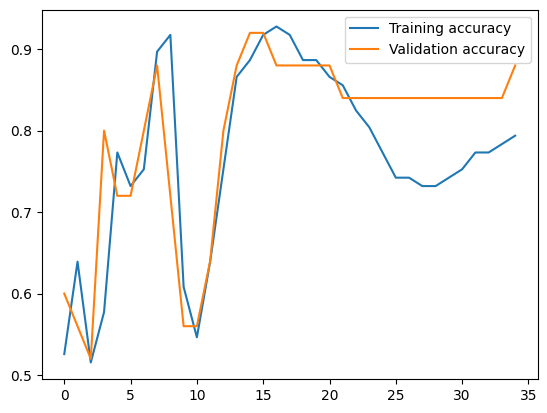

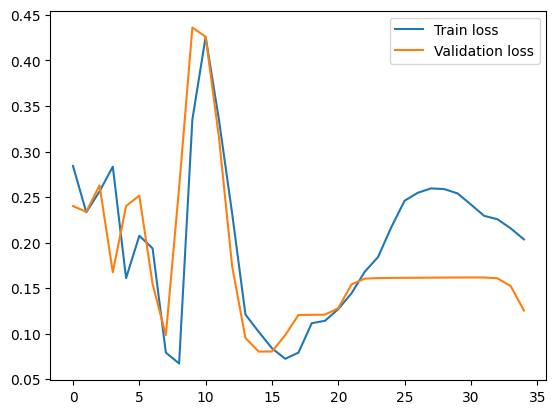

14/14 [==============================] - 0s 1ms/step - loss: 0.1708 - accuracy: 0.8241
[0.17075084149837494, 0.8240740895271301]


In [29]:
model = grid_search(params, x_train, y_train, hold_out_val)
test_model(model, x_test, y_test)